In [6]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hsv_to_rgb
from tensorboard import SummaryWriter
from scipy.stats import multivariate_normal

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [2]:
def plot_transition(d, rotate=False):
    
    if rotate:
        d = d.copy()
        
        # translate
        dx, dy = d[['y0', 'y1']]
        d[['x0', 'y0', 'y_0']] -= dx
        d[['x1', 'y1', 'y_1']] -= dy
        
        # rotate
        θ = -d['y2']
        for prefix in ['x', 'x_', 'y_', 'u', 'y']:
            x = d[prefix + '0'].copy()
            y = d[prefix + '1'].copy()
            d[prefix + '0'] = np.cos(θ) * x - np.sin(θ) * y
            d[prefix + '1'] = np.sin(θ) * x + np.cos(θ) * y
            if prefix is not 'u':
                d[prefix + '2'] += θ

    k = 0.05
    head_width=0.02
    plt.arrow(d['x0'], d['x1'],  k * np.cos(d['x2']), k * np.sin(d['x2']), head_width=head_width, color='black')
    plt.arrow(d['x0'], d['x1'], -k * np.sin(d['x2']), k * np.cos(d['x2']), head_width=head_width, color='black')
    
    plt.arrow(d['x_0'], d['x_1'],  k * np.cos(d['x_2']), k * np.sin(d['x_2']), head_width=head_width, color='grey')
    plt.arrow(d['x_0'], d['x_1'], -k * np.sin(d['x_2']), k * np.cos(d['x_2']), head_width=head_width, color='grey')

    plt.arrow(d['y0'], d['y1'],  k * np.cos(d['y2']), k * np.sin(d['y2']), head_width=head_width, color='red')
    plt.arrow(d['y0'], d['y1'], -k * np.sin(d['y2']), k * np.cos(d['y2']), head_width=head_width, color='red')

    plt.arrow(d['y_0'], d['y_1'],  k * np.cos(d['y_2']), k * np.sin(d['y_2']), head_width=head_width, color='pink')
    plt.arrow(d['y_0'], d['y_1'], -k * np.sin(d['y_2']), k * np.cos(d['y_2']), head_width=head_width, color='pink')

    t = d['u3']
    plt.arrow(d['x0'], d['x1'],  t * d['u0'], t * d['u1'], head_width=0.03, color='blue')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.grid()

In [3]:
types = {
    'x0': np.float32,
    'x1': np.float32,
    'x2': np.float32,
    'y0': np.float32,
    'y1': np.float32,
    'y2': np.float32,
    'x_0': np.float32,
    'x_1': np.float32,
    'x_2': np.float32,
    'y_0': np.float32,
    'y_1': np.float32,
    'y_2': np.float32,
    'u0': np.float32,
    'u1': np.float32,
    'u2': np.float32,
    'u3': np.float32,
    'u4': np.float32,
    'w': np.float32,
    'h': np.float32,
    'm': np.float32,
    'I': np.float32,
    'µ': np.float32,
    'type': str
}
dataset = pd.read_csv('./data/data/concatenated.csv', dtype=types, sep='\s*,\s*', engine='python')

In [4]:
mask = (
    (dataset['y_0'] == dataset['y0']) &
    (dataset['y_1'] == dataset['y1']) &
    (dataset['y_2'] == dataset['y2'])
)
non_moving = dataset[mask][['y0', 'y1', 'y2', 'y_0', 'y_1', 'y_2']]
sub_dataset = dataset.drop(non_moving.sample(frac=0.9).index)

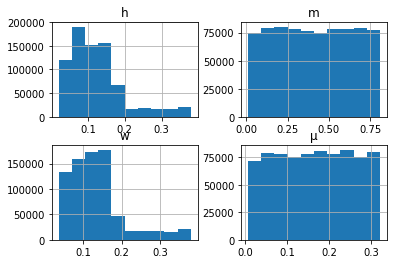

(m    0.410449
 µ    0.164939
 w    0.134343
 h    0.125184
 dtype: float32, m    0.028865
 µ    0.011310
 w    0.008981
 h    0.009448
 dtype: float32)

In [5]:
sub_dataset[['m', 'µ', 'w', 'h']].hist()
plt.show()
x = sub_dataset[['m', 'µ', 'w', 'h']]
µ = sub_dataset[['m', 'µ', 'w', 'h']].mean()
Σ = sub_dataset[['m', 'µ', 'w', 'h']].var() / (8.0 ** 2)
sampling_probs = multivariate_normal.pdf(x, mean=µ, cov=Σ)
µ, np.sqrt(Σ)

In [6]:
dataset_train = sub_dataset.iloc[:int(0.8 * sub_dataset.shape[0])]
sampling_probs_train = sampling_probs[:int(0.8 * sub_dataset.shape[0])]
dataset_val = sub_dataset.iloc[int(0.8 * sub_dataset.shape[0]):int(0.9 * sub_dataset.shape[0])]
sampling_probs_val = sampling_probs[int(0.8 * sub_dataset.shape[0]):int(0.9 * sub_dataset.shape[0])]
dataset_test = sub_dataset.iloc[int(0.9 * sub_dataset.shape[0]):]
sampling_probs_test = sampling_probs[int(0.9 * sub_dataset.shape[0]):]

In [7]:
class PushingDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe):
        self.df = dataframe
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        
        x = row[['y0', 'y1', 'y2', 'w', 'h']].values
        #x[:2] += np.random.randn(2)
        #x[2] += np.random.randn(1)
        u = row[['u0', 'u1', 'u2', 'u3']].values
        y_ = row[['y_0', 'y_1', 'y_2']].values
        y = y_ - x[:3]
        y[-1] = np.arctan2(np.sin(y[-1]), np.cos(y[-1]))

        #plt.figure(figsize=(6, 6))
        #plot_transition(row)
        #plt.show()

        return (
            x.astype(np.float32),
            u.astype(np.float32),
            y.astype(np.float32),
        )
                
    def __len__(self):
        return self.df.shape[0]
    
from torch.utils.data.sampler import WeightedRandomSampler
train_size = 256
train_sampler = WeightedRandomSampler(sampling_probs_train, len(dataset_train))
val_sampler = WeightedRandomSampler(sampling_probs_val, len(dataset_val))
test_sampler = WeightedRandomSampler(sampling_probs_test, len(dataset_test))
    
pushing_dataset_train = PushingDataset(dataset_train)
pushing_dataset_val = PushingDataset(dataset_val)
pushing_dataset_test = PushingDataset(dataset_test)
dataloader_train = DataLoader(pushing_dataset_train, pin_memory=True, sampler=train_sampler, batch_size=train_size, num_workers=6)
dataloader_val = DataLoader(pushing_dataset_val, pin_memory=True, sampler=val_sampler, batch_size=256)
dataloader_test = DataLoader(pushing_dataset_test, pin_memory=True, sampler=test_sampler, batch_size=1)
next(iter(dataloader_test))

[
  0.5083 -0.0526 -2.7133  0.1310  0.1310
 [torch.FloatTensor of size 1x5], 
 -0.3415 -0.4484  0.3632  0.0619
 [torch.FloatTensor of size 1x4], 
 1.00000e-07 *
   0.0000 -1.0058  0.0000
 [torch.FloatTensor of size 1x3]]

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance
- Learn: $p(u|x_r, x_t, x_t')$

In [12]:
class Normalization(torch.nn.Module):
    
    def __init__(self, n_features):
        super(Normalization, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return (x - Variable(self.mean)) / Variable(self.std)
    
class NormalizationInverse(torch.nn.Module):
    
    def __init__(self, n_features):
        super(NormalizationInverse, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return x * Variable(self.std) + Variable(self.mean)

In [9]:
def normalizers(sub_dataset):
    mean = sub_dataset.mean().values
    std = sub_dataset.std().values
    norm = Normalization(mean.shape[0])
    norm_inv = NormalizationInverse(mean.shape[0])
    norm.mean = norm_inv.mean = torch.FloatTensor(mean)
    norm.std = norm_inv.std = torch.FloatTensor(std)
    return norm.cuda(), norm_inv.cuda()

x_dataset = dataset_train[['y0', 'y1', 'y2', 'w', 'h']]
u_dataset = dataset_train[['u0', 'u1', 'u2', 'u3']]
y_dataset = dataset_train[['y_0', 'y_1', 'y_2']] - dataset_train[['y0', 'y1', 'y2']].values
norm_x, norminv_x = normalizers(x_dataset)
norm_u, norminv_u = normalizers(u_dataset)
norm_y, norminv_y = normalizers(y_dataset)
norm_y.mean *= 0.0
norminv_y.mean *= 0.0

In [10]:
class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x

In [11]:
class RewardFCPlain(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=64):
        super(RewardFCPlain, self).__init__()
        
        self.fc1 = torch.nn.Linear(x_size + u_size, hidden_units)
        self.bn1 = torch.nn.BatchNorm1d(hidden_units)
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.bn2 = torch.nn.BatchNorm1d(hidden_units)
        self.fcy = torch.nn.Linear(hidden_units, y_size)  # E[Y]
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        a1 = F.relu(self.bn1(self.fc1(xu)))
        a2 = F.relu(self.bn2(self.fc2(a1)))
        y = self.fcy(a2)                        # E(Y)
        # Var(Y) = E(Y^2) - E(Y)^2
        # E(Y^2) = Var(Y) + E(Y)^2
        # y2 = F.softplus(self.fcy2(a2)) + y ** 2 # E(Y^2)
        # t = F.softplus(self.fct(a2))
        return y

class FCPositive(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=64):
        super(FCPositive, self).__init__()
        
        self.fc1 = torch.nn.Linear(x_size + u_size, hidden_units)
        self.bn1 = torch.nn.BatchNorm1d(hidden_units)
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.bn2 = torch.nn.BatchNorm1d(hidden_units)
        self.fcy = torch.nn.Linear(hidden_units, y_size)  # E[Y]
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        a1 = F.relu(self.bn1(self.fc1(xu)))
        a2 = F.relu(self.bn2(self.fc2(a1)))
        y = F.softplus(self.fcy(a2))
        return y
    
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
reward = RewardFCPlain(X.size(1), U.size(1), Y.size(1)).cuda()
variance = FCPositive(X.size(1), U.size(1), Y.size(1)).cuda()
optim_mean = torch.optim.Adam(reward.parameters(), weight_decay=1e-2)
optim_variance = torch.optim.Adam(variance.parameters(), weight_decay=1e-2)
loss_fn = torch.nn.MSELoss()

In [20]:
time_str = datetime.datetime.now().strftime('%H:%M')
logger_train = SummaryWriter('runs/reward-{}-mse-train'.format(time_str))
logger_valid = SummaryWriter('runs/reward-{}-mse-valid'.format(time_str))
best_val = np.inf
best_models = None
step = -1
n_steps = 7500
while True:
    for X, U, Y in dataloader_train:
        reward.train()
        step += 1
        X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
        X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
        Y_pred = reward(X, U)
        Y2_pred = variance(X, U)
        loss_mean = loss_fn(Y_pred, Y)
        loss_variance = loss_fn(Y2_pred, Variable(((Y - Y_pred) ** 2).data))
        reward.zero_grad()
        variance.zero_grad()
        loss_mean.backward()
        loss_variance.backward()
        optim_mean.step()
        optim_variance.step()
        if step % 50 == 0:
            logger_train.add_scalar('loss mean', loss_mean.cpu().data[0], step)
            logger_train.add_scalar('loss variance', loss_variance.cpu().data[0], step)
            
            # validation
            reward.eval()
            X, U, Y = next(iter(dataloader_val))
            X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
            X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
            Y_pred = reward(X, U)
            Y2_pred = variance(X, U)
            loss_mean = loss_fn(Y_pred, Y)
            loss_variance = loss_fn(Y2_pred, Variable(((Y - Y_pred) ** 2).data))
            logger_valid.add_scalar('loss mean', loss_mean.cpu().data[0], step)
            logger_valid.add_scalar('loss variance', loss_variance.cpu().data[0], step)
            val_loss = loss_mean.cpu().data[0]
            if step == 2000:
                optim_mean = torch.optim.SGD(reward.parameters(), lr=1e-3, weight_decay=1e-2)
                optim_variance = torch.optim.SGD(variance.parameters(), lr=1e-3, weight_decay=1e-2)
            if val_loss < best_val:
                best_val = val_loss
                best_models = reward.state_dict(), variance.state_dict()
        if step > n_steps:
            break
    if step > n_steps:
        break

In [22]:
reward.eval()
variance.eval()
reward.load_state_dict(best_models[0])
variance.load_state_dict(best_models[1])
with open('notebook_models/reward.pkl', 'wb') as f:
    pickle.dump(reward.state_dict(), f)
with open('notebook_models/variance.pkl', 'wb') as f:
    pickle.dump(variance.state_dict(), f)
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
X, U, Y = norm_x(X)[:1, :], norm_u(U)[:1, :], norm_y(Y)[:1, :]

In [13]:
with open('notebook_models/reward.pkl', 'rb') as f:
    reward.load_state_dict(pickle.load(f))
with open('notebook_models/variance.pkl', 'rb') as f:
    variance.load_state_dict(pickle.load(f))

In [14]:
class ExpectedDistance(torch.nn.Module):
    
    def __init__(self, mean_model, variance_model):
        super(ExpectedDistance, self).__init__()
        self.mean = mean_model
        self.variance = variance_model
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1])
        )
        
    def forward(self, x, u, g):
        """
        Variables should all be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).mean(dim=1)
    
expect_distance = ExpectedDistance(reward, variance).cuda()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
norm_x = norm_x.cuda()
norm_u = norm_u.cuda()
norm_y = norm_y.cuda()
expect_distance(norm_x(X), norm_u(U), norm_y(Y))

Variable containing:
 0.1165
 0.0503
 0.1470
 0.1148
 0.1527
 0.5380
 0.1681
 0.0982
 0.0801
 0.3547
 0.0625
 0.6059
 0.4616
 0.0383
 0.0959
 0.1162
 0.0383
 0.0764
 0.1108
 0.2766
 0.1622
 0.0743
 0.1596
 0.0755
 0.1509
 0.0954
 0.0925
 0.3283
 0.0642
 0.0696
 0.3547
 0.1148
 0.0682
 0.1524
 0.0838
 0.1107
 0.1191
 0.1588
 0.1446
 0.6059
 0.1056
 0.1114
 0.2260
 0.0709
 0.1514
 0.0669
 0.1255
 0.1282
 0.1040
 0.1282
 0.0625
 0.0624
 0.0691
 0.0675
 0.2260
 0.1596
 0.1121
 0.0669
 0.1289
 0.3283
 0.1056
 0.1047
 0.1108
 0.0695
 0.0755
 0.0675
 0.1126
 0.0650
 0.0764
 0.2145
 0.0925
 0.1387
 0.0980
 0.0868
 0.1596
 0.0951
 0.0625
 0.1527
 0.1373
 0.1113
 0.1520
 0.0681
 0.1809
 0.1206
 0.1170
 0.0925
 0.0383
 0.1638
 0.2146
 0.0857
 0.0625
 0.0515
 0.0838
 0.6194
 0.0925
 0.0670
 0.0641
 0.1405
 0.0783
 0.0954
 0.1384
 0.4054
 0.0963
 0.0683
 0.1524
 0.0695
 0.1206
 0.2108
 0.0980
 0.4054
 0.0383
 0.1514
 0.0691
 0.0669
 0.2553
 0.1191
 0.2405
 0.1068
 0.0940
 0.1137
 0.0581
 0.0755
 0.

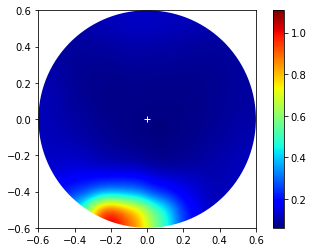

In [15]:
def plot_q(π=None, X=None, G=None, duration=0.6):
    reward.eval()
    variance.eval()
    obj_x = 0.3; obj_y = 0.0
    width = 0.10
    if X is None:
        X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width]]))
    else:
        X = X[:1, :]
    _, U, Y = next(iter(dataloader_val))
    U = Variable(U.cuda())[:1, :]
    g = 0.1 * np.array([obj_x, obj_y, 0.0]) / np.sqrt(obj_x ** 2 + obj_y ** 2)
    if G is None:
        G = Variable(torch.cuda.FloatTensor(g)).resize(1, 3)
    else:
        G = G[:1, :]
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        duration = float(U[-1])
    U = Variable(torch.cuda.FloatTensor([[0.0, 0.0, 0.0, duration]]))
    
    res = 8
    u_range = 0.6
    img = np.zeros((res, res))
    img_var = np.zeros((res, res))
    for i, ux in enumerate(np.linspace(-u_range, u_range, res)):
        for j, uy in enumerate(np.linspace(-u_range, u_range, res)):
            U[0, 0] = ux
            U[0, 1] = uy
            d = expect_distance(norm_x(X), norm_u(U), norm_y(G)).cpu().data[0]
            img[j, i] = d
            
    fig, ax = plt.subplots(figsize=(6, 4))
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        plt.plot(U[0], U[1], 'ko', markersize=5.0)
        plt.plot(U[0], U[1], 'wo', markersize=4.0)
    circle = plt.Circle((0, 0), radius=u_range + 0.69, fill=False, linewidth=250, color='white')
    mappable = ax.imshow(img, extent=[-u_range, u_range, -u_range, u_range], origin='lower', interpolation='gaussian', cmap='jet')
    ax.add_artist(circle)
    ax.plot(0, 0, 'w+')
    plt.colorbar(mappable=mappable)
    plt.show()

X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
plot_q(X=X, G=Y)

In [16]:
class Policy(torch.nn.Module):
    
    def __init__(self, x_size, g_size, u_size, hidden_size=64):
        super(Policy, self).__init__()
        self.fc1 = torch.nn.Linear(x_size + g_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_xy_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_xy_dir = torch.nn.Linear(hidden_size, 2)
        self.fc_r_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_dur = torch.nn.Linear(hidden_size, 1)
        self.register_buffer(
            'xy_vel_scale',
            torch.FloatTensor([0.6])
         )
        self.register_buffer(
            'r_vel_scale',
            torch.FloatTensor([1.4])
         )
        self.register_buffer(
            'dur_scale',
            torch.FloatTensor([0.6])
         )
        
    def forward(self, x, g):
        xg = torch.cat([x, g], dim=1)
        a1 = F.relu(self.fc1(xg))
        a2 = F.relu(self.fc2(a1))
        u_xy_vel = F.sigmoid(self.fc_xy_vel(a2))
        u_xy_dir = F.tanh(self.fc_xy_dir(a2))
        u_r_vel = F.tanh(self.fc_r_vel(a2))
        u_dur = F.sigmoid(self.fc_dur(a2))
        return torch.cat(
            [
                Variable(self.xy_vel_scale) * u_xy_vel * u_xy_dir / u_xy_dir.norm(dim=1, keepdim=True),
                Variable(self.r_vel_scale) * u_r_vel,
                Variable(self.dur_scale) * u_dur,
            ],
            dim=1
        )
        
X, U, Y = next(iter(dataloader_val))
π = Policy(X.size(1), Y.size(1), U.size(1)).cuda()
X, Y = map(lambda x: Variable(x.cuda()), [X, Y])
policy_opt = torch.optim.Adam(π.parameters())
norm_x.cuda()
norm_u.cuda()
norm_y.cuda()

Normalization (
)

In [600]:
time_str = datetime.datetime.now().strftime('%H:%M')
reward.eval()
variance.eval()
logger_policy = SummaryWriter('runs/policy-{}-mse-train'.format(time_str))
step = -1
n_steps = 10000
while True:
    for X, _, Y in dataloader_train:
        π.train()
        π.zero_grad()
        step += 1
        X = Variable(X.cuda())
        Y = Variable(Y.cuda())
        change_goal = Variable(torch.rand(Y.size(0), 1) < 1.5).cuda().float()
        G_normed = norm_y(Y * change_goal) + (1 - change_goal) * Variable(torch.randn(Y.size())).cuda()
        U = π(norm_x(X), G_normed)
        action_regularizer = (U ** 2).sum() / U.size(0)
        loss = expect_distance(norm_x(X), norm_u(U), G_normed).mean() + action_regularizer
        loss.backward()
        policy_opt.step()
        logger_policy.add_scalar('cost', loss.cpu().data[0], step)
        if step >= n_steps:
            break
    if step >= n_steps:
        break

In [17]:
#with open('notebook_models/policy.pkl', 'wb') as f:
#    pickle.dump(π.state_dict(), f)
with open('notebook_models/policy.pkl', 'rb') as f:
    π.load_state_dict(pickle.load(f))

In [18]:
class ProductionPolicy(torch.nn.Module):
    
    def __init__(self, norm_x, norm_y, policy):
        super(ProductionPolicy, self).__init__()
        self.norm_x = norm_x
        self.norm_y = norm_y
        self.policy = policy
        
    def forward(self, x, g):
        return self.policy(self.norm_x(x), self.norm_y(g))

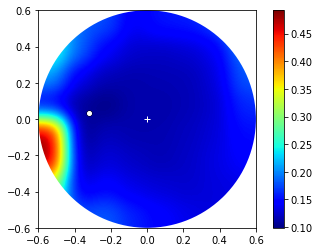

In [19]:
production_policy = ProductionPolicy(norm_x, norm_y, π).cuda()
production_policy.eval()
obj_x = 0.0
obj_y = 0.3
goal_x = 0.0
goal_y = 0.1
width = 0.10
X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width]]))
G = Variable(torch.cuda.FloatTensor([[goal_x, goal_y, 0.0]]))

X, U, G = next(iter(dataloader_val))
X = Variable(X.cuda())
G = Variable(G.cuda())
U = production_policy(X, G)
π = π.cuda()
plot_q(X=X, G=G, π=π)
#print('Rotation:', U.cpu().data[0, -2])
#print('Duration:', U.cpu().data[0, -1])

In [668]:
production_policy = production_policy.cpu()
with open('saved_models/production_policy.pkl', 'wb') as f:
    pickle.dump(production_policy.state_dict(), f)
production_policy = production_policy.cuda()

In [23]:
production_policy.cpu()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x), [X, U, Y])
Y[0], U[0], production_policy(X, Y)[0]

(Variable containing:
 1.00000e-02 *
   2.1740
  -2.8396
  -3.6060
 [torch.FloatTensor of size 3], Variable containing:
  0.1114
 -0.0344
 -1.3249
  0.1277
 [torch.FloatTensor of size 4], Variable containing:
  0.2101
 -0.1390
 -0.0360
  0.1163
 [torch.FloatTensor of size 4])

In [ ]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

# Feasibility (MCMC)

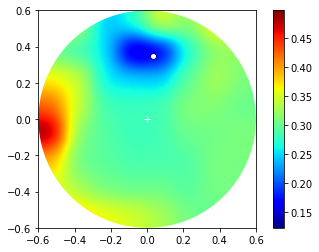

0.14225102961063385

In [21]:
class ExpectedDistanceProduction(torch.nn.Module):
    
    def __init__(self, policy, mean_model=None, variance_model=None, x_norm=None, u_norm=None, y_norm=None):
        super(ExpectedDistanceProduction, self).__init__()
        self.policy = policy
        self.mean = mean_model
        self.variance = variance_model
        self.x_norm = x_norm
        self.u_norm = u_norm
        self.g_norm = y_norm
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1])
        )
        
    def forward(self, x, g):
        """
        Variables should all be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        x = self.x_norm(x)
        g = self.g_norm(g)
        u = self.u_norm(self.policy(x, g))
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).mean(dim=1)
    
    
edp = ExpectedDistanceProduction(π, mean_model=reward, variance_model=variance, x_norm=norm_x, u_norm=norm_u, y_norm=norm_y).cuda()
#X, U, G = next(iter(dataloader_val))
#X, U, G = map(lambda x: Variable(x.cuda()), [X, U, G])
X = Variable(torch.cuda.FloatTensor([[0.0, 0.2, 0.0, 0.1, 0.1]]))
G = Variable(torch.cuda.FloatTensor([[0.0, 0.1, 0.0]]))
plot_q(X=X, G=G, π=π)
#with open('saved_models/expected_distance.pkl', 'wb') as f:
#    pickle.dump(edp.state_dict(), f)
edp(X[:1, :], G[:1, :]).cpu().data[0]

0.0887924805284 0.11452390564 0.134869232774


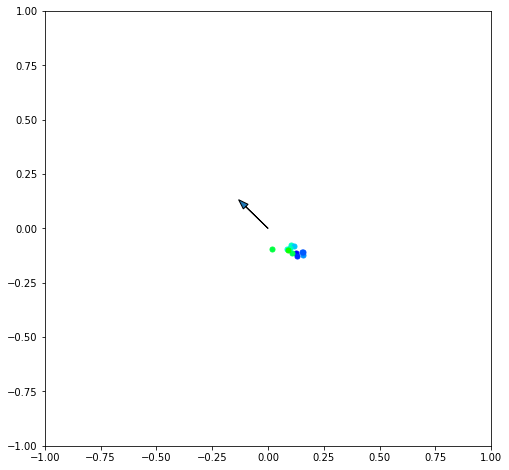

In [770]:
def _proposal2state(θ_obj, θ_rob, x_rob, y_rob, dx, dy, dθ):
    obj_x =  np.cos(θ_rob) * (-x_rob) + np.sin(θ_rob) * (-y_rob)
    obj_y = -np.sin(θ_rob) * (-x_rob) + np.cos(θ_rob) * (-y_rob)
    obj_θ = θ_obj - θ_rob
    goal_x = np.cos(θ_rob) * dx + np.sin(θ_rob) * dy
    goal_y = -np.sin(θ_rob) * dx + np.cos(θ_rob) * dy
    
    return obj_x, obj_y, obj_θ, goal_x, goal_y, dθ

def _energy(θ_obj, θ_rob_prop, x_rob_prop, y_rob_prop, dx, dy, dθ, width, height, expect_distance):
    obj_x, obj_y, obj_θ, goal_x, goal_y, dθ = _proposal2state(θ_obj, θ_rob_prop, x_rob_prop, y_rob_prop, dx, dy, dθ)
    X = Variable(torch.FloatTensor([[obj_x, obj_y, obj_θ, width, height]]))
    G = Variable(torch.FloatTensor([[goal_x, goal_y, dθ]]))
    U = edp(X, G)
    return U.cpu().data[0]


# Just give change of state, (and object width, height)
# Then sample different poses of robot (as markov chain) and rotate/translate object accordingly
# Run k times and return last sample
def foo(θ_obj, dx, dy, dθ, width, height, expect_distance):
    # select initial robot position relative object
    θ_rob = np.arctan2(dy, dx) - np.pi / 2.0
    x_rob = -0.25 * np.cos(θ_rob + np.pi / 2.0)
    y_rob = -0.25 * np.sin(θ_rob + np.pi / 2.0)
    
    U = _energy(θ_obj, θ_rob, x_rob, y_rob, dx, dy, dθ, width, height, expect_distance)
    
    while True:
        θ_rob_prop = θ_rob + np.random.randn() * 0.5
        θ_rob_prop = np.arctan2(np.sin(θ_rob_prop), np.cos(θ_rob_prop))
        x_rob_prop = x_rob + np.random.randn() * 0.05
        y_rob_prop = y_rob + np.random.randn() * 0.05
        # The reward function is not defined for robot positions further away
        #if np.linalg.norm([x_rob_prop, y_rob_prop]) > 0.3:
        #    continue
        
        U_ = _energy(θ_obj, θ_rob_prop, x_rob_prop, y_rob_prop, dx, dy, dθ, width, height, expect_distance)
        T = 1e-2
        p = min(1, np.exp((U - U_) / T))
        if np.random.rand() < p:
            θ_rob = θ_rob_prop
            x_rob = x_rob_prop
            y_rob = y_rob_prop
            U = U_
            yield x_rob, y_rob, θ_rob, U_
        
from matplotlib.colors import hsv_to_rgb

plt.figure(figsize=(8, 8))
edp = edp.cpu()
dx = -0.1
dy = 0.1
θ = np.arctan2(dy, dx)
dθ = 0.0
us = []
plt.arrow(0, 0, dx, dy, head_width=0.03)
for i, (x, y, θ, u) in enumerate(foo(θ, dx=dx, dy=dy, dθ=dθ, width=0.1, height=0.1, expect_distance=edp)):
    us.append(u)
    hue = (θ + np.pi) / (2 * np.pi)
    plt.plot(x, y, '.', color=hsv_to_rgb((hue, 1, 1.0)), markersize=10.0, alpha=1.0)
    #plt.plot(x, y, 'k.', markersize=10.0, alpha=(1.2 - u) / 0.2)
    #plt.arrow(x, y, 0.03 * np.cos(θ + np.pi / 2), 0.03 * np.sin(θ + np.pi / 2), head_width=0.01)
    if i > 10:
        break
print(np.min(us), np.mean(us), np.max(us))
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()

In [248]:
plt.close()

# Closed form of MCMC

In [ ]:
def to_object_centric(X, Y):
    """returns (width, height, dx, dy, dθ), all in object frame"""
    res = torch.zeros(X.size(0), 5)
    res[:, 0] = X[:, -2] # width
    res[:, 1] = X[:, -1] # height
    θ = X[:, 2]
    res[:, 2] = Y[:, 0] * torch.cos(θ) + Y[:, 1] * torch.sin(θ)
    res[:, 3] = -Y[:, 0] * torch.sin(θ) + Y[:, 1] * torch.cos(θ)
    res[:, -1] = Y[:, -1]
    return res
        
def to_robot_centric(robot, obj):
    """
    Expects (in object centric frame):
    robot : (x_robot, y_robot, θ_robot)
    obj   : (width, height, dx, dy, dθ)
    
    Returns (in robot frame):
    X : (obj_x', obj_y', obj_θ', width, height)
    Y : (dx', dy', dθ')
    """
    X = Variable(torch.zeros(robot.size(0), 5))
    Y = Variable(torch.zeros(robot.size(0), 3))
    if robot.is_cuda:
        X = X.cuda()
        Y = Y.cuda()
    θ = robot[:, -1]
    X[:, 0] = -robot[:, 0] * torch.cos(θ) - robot[:, 1] * torch.sin(θ)
    X[:, 1] = robot[:, 0] * torch.sin(θ) - robot[:, 1] * torch.cos(θ)
    X[:, 2] = torch.atan2(torch.sin(-θ), torch.cos(-θ))
    X[:, -2] = obj[:, 0]
    X[:, -1] = obj[:, 1]
    Y[:, 0] = obj[:, 2] * torch.cos(θ) + obj[:, 3] * torch.sin(θ)
    Y[:, 1] = -obj[:, 2] * torch.sin(θ) + obj[:, 3] * torch.cos(θ)
    Y[:, 2] = obj[:, -1]
    return X, Y

class ObjectCentric2Energy(torch.nn.Module):
    
    def __init__(self, expected_distance_production):
        super(ObjectCentric2Energy, self).__init__()
        self.edp = expected_distance_production
        
    def forward(self, rob, obj):
        X, Y = to_robot_centric(rob, obj)
        U = edp(X, Y)
        return U
    
def grad_U(rob, obj, model):
    model.zero_grad()
    U = model(rob, obj)
    grad, = torch.autograd.grad([U[i:i+1] for i in range(U.size(0))],
                                rob)
    return grad
    

def next_robot(rob, obj, energy_fn):
    """
    rob : torch.FloatTensor
    obj : torch.FloatTensor
    """
    obj = Variable(obj)
    rob_np = rob.cpu().numpy().copy()
    p_np = np.random.randn(*rob_np.shape) * np.array([0.1, 0.1, 1.5])
    current_q = Variable(torch.FloatTensor(rob_np), requires_grad=True)
    q = Variable(torch.FloatTensor(rob_np), requires_grad=True)

    L = 10
    epsilon = 0.2 / L

    # start HMC (http://www.mcmchandbook.net/HandbookChapter5.pdf p. 125)

    current_p = Variable(torch.FloatTensor(p_np))
    p = Variable(torch.FloatTensor(p_np))
    
    if rob.is_cuda:
        q = q.cuda()
        p = p.cuda()
        current_q = current_q.cuda()
        current_p = current_p.cuda()
    
    # Make half a step for momentum at the beginning
    p = p - epsilon * grad_U(q, obj, energy) / 2

    for l in range(L):
        q.data += epsilon * p.data
        q.data[:, -1] = torch.atan2(torch.sin(q.data[:, -1]), torch.cos(q.data[:, -1]))
        #plt.plot(q.data[0, 0], q.data[0, 1], 'bo', markersize=1.0)
        if l < L - 1:
            p = p - epsilon * grad_U(q, obj, energy)

    # Make half a step for momentum at the end
    p = p - epsilon * grad_U(q, obj, energy) / 2
    p = -p

    current_U = energy(current_q, obj)
    current_K = (current_p ** 2).sum(dim=1) / 2.0
    proposed_U = energy(q, obj)
    proposed_K = (p ** 2).sum(dim=1) / 2.0
    
    # Acceptance probability
    ones = Variable(torch.ones(current_U.size()))
    if rob.is_cuda:
        ones = ones.cuda()
    prob = torch.min(
        ones,
        torch.exp((current_U - proposed_U) / 1e-3 + (current_K - proposed_K) / 1.0))
    mask = torch.bernoulli(prob)
    res = q * mask.view(-1, 1) + current_q * (1 - mask).view(-1, 1)
    return res.data

    
edp.eval()
energy = ObjectCentric2Energy(edp.cuda())
energy = energy.cuda()

def iter_hmc_samples(dataloader, samples_per_setup=64):
    while True:
        for X, _, Y in dataloader:
            O = to_object_centric(X, Y)
            R = torch.randn(O.size(0), 3) * torch.FloatTensor([0.01, 0.01, 3]) * 0.0
            R[:, -1] = torch.atan2(torch.sin(R[:, -1]), torch.cos(R[:, -1]))
            O = O.cuda()
            R = R.cuda()

            n_burn_in = 32
            for i in range(samples_per_setup + n_burn_in):
                R = next_robot(R, O, energy)
                if i < n_burn_in:
                    continue
                R_ = torch.zeros(R.size(0), 4)
                R_[:, :2] = R[:, :2]
                R_[:, -2] = torch.cos(R[:, -1])
                R_[:, -1] = torch.sin(R[:, -1])
                yield O, R_
                

#dataset_feasibility = []

#logger = SummaryWriter('./runs/data-gen')

for i, (o, r) in enumerate(iter_hmc_samples(dataloader_train)):
    o_np = [o_ for o_ in o.cpu().numpy()]
    r_np = [r_ for r_ in r.cpu().numpy()]
    dataset_feasibility.extend(zip(o_np, r_np))
    #logger.add_scalar('progress', i / (32 * 64), i)
    if i >= 32 * 128 - 1:
        break

In [2]:
#with open('./dataset_feasibility.pkl', 'wb') as f:
#    pickle.dump(dataset_feasibility, f)
with open('./dataset_feasibility.pkl', 'rb') as f:
    dataset_feasibility = pickle.load(f)
len(dataset_feasibility)

1572864

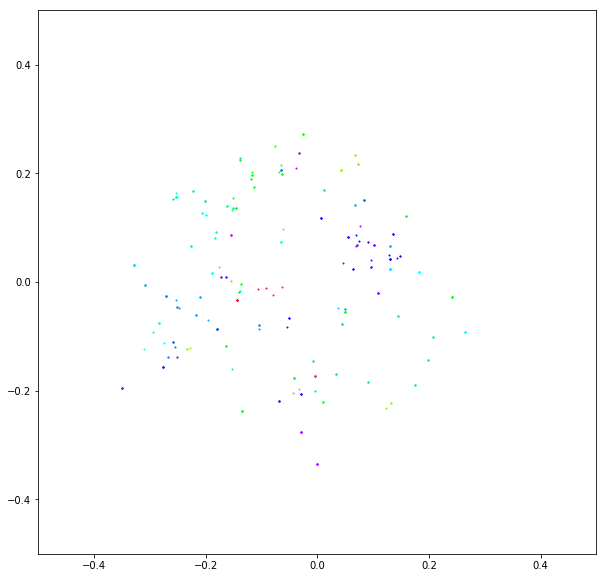

1572864

In [8]:
plt.close()
plt.figure(figsize=(10, 10))
for o, r in dataset_feasibility[:1000]:
    θ = np.arctan2(r[-1], r[-2])
    hue = (θ + np.pi) / (2 * np.pi)
    if np.linalg.norm(o[2:4]) > 0.05:
        plt.plot(r[0], r[1], 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=1.0, alpha=1.0)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.show()
len(dataset_feasibility)

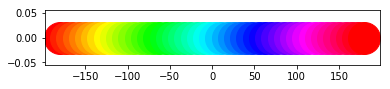

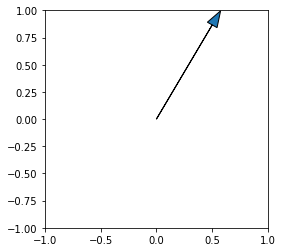

In [1072]:
plt.figure(figsize=(6, 1))
for θ in np.linspace(-np.pi, np.pi):
    hue = (θ + np.pi) / (2 * np.pi)
    plt.plot(θ / np.pi * 180, 0, 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=32)
plt.show()
test_angle = -30
θ = test_angle / 180 * np.pi
plt.figure(figsize=(4, 4))
plt.arrow(0.0, 0.0, -np.sin(θ), np.cos(θ), head_width=0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


In [50]:
# Normalize target distribution
robot_norm = Normalization(4)
robot_norm.std = torch.cuda.FloatTensor([0.4, 0.4, 1.0, 1.0]) # picked by eyeballing

robot_norminv = NormalizationInverse(4)
robot_norminv.std = robot_norm.std

robot_norm = robot_norm.cuda()
robot_norminv = robot_norminv.cuda()

# Normalize input data
obs_norm = Normalization(5)
obs_norm.std = torch.cuda.FloatTensor([0.16, 0.16, 0.5, 0.5, 2.0]) # picked by eyeballing

obs_norminv = NormalizationInverse(5)
obs_norminv.std = obs_norm.std

obs_norm = obs_norm.cuda()
obs_norminv = obs_norminv.cuda()

In [296]:
class FeasibilityGenerator(torch.nn.Module):
    
    def __init__(self):
        super(FeasibilityGenerator, self).__init__()
        observation_size = 5
        output_size = 4
        self.latent_size = 11
        hidden_size = 256
        input_size = self.latent_size + observation_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.norm1 = torch.nn.BatchNorm1d(hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm2 = torch.nn.BatchNorm1d(hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm3 = torch.nn.BatchNorm1d(hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, output_size)
        self.train()
    
    def forward(self, obj):
        """
        Expects obj: (width, height, dx, dy, dθ)
        """
        z = Variable(torch.randn(obj.size(0), self.latent_size))
        if obj.is_cuda:
            z = z.cuda()
        inputs = torch.cat([obj, z], dim=1)
        y1 = F.leaky_relu(self.norm1(self.fc1(inputs)))
        y2 = F.leaky_relu(self.norm2(self.fc2(y1)))
        y3 = F.leaky_relu(self.norm3(self.fc3(y2)))
        y4 = F.leaky_relu(self.fc4(y3))
        y = F.tanh(self.fcy(y4))
        return y


class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        input_size = 5 + 4
        hidden_size = 256
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, 1)
        self.train()
        
    def forward(self, obj, rob):
        inputs = torch.cat([obj, rob], dim=1)
        y1 = F.leaky_relu(self.fc1(inputs))
        y2 = F.leaky_relu(self.fc2(y1))
        y3 = F.leaky_relu(self.fc3(y2))
        logits = F.relu(self.fc4(y3))
        y = F.sigmoid(self.fcy(logits))
        return logits, y

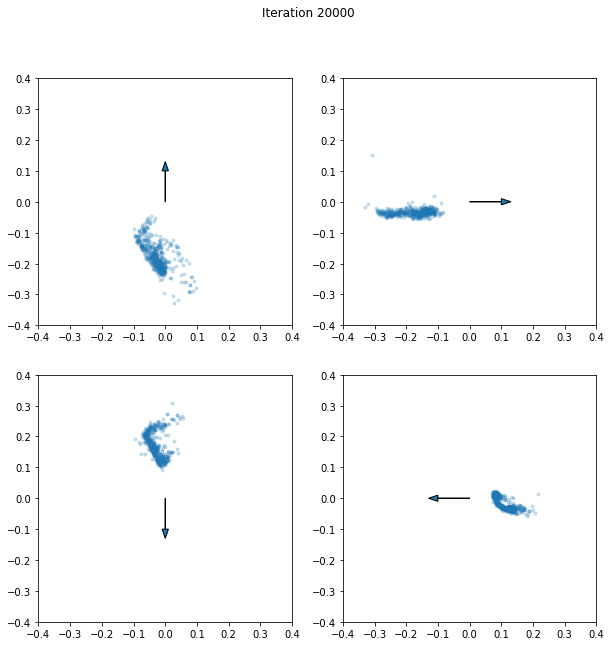

In [565]:
def plot_generator(generator, iteration, path=None, k=0.1):
    generator.eval()
    os = [
        Variable(torch.FloatTensor([[0.13, 0.13, 0, k, 0.0]]).repeat(512, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13, k, 0, 0.0]]).repeat(512, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13, 0,-k, 0.0]]).repeat(512, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13,-k, 0, 0.0]]).repeat(512, 1)),
    ]
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    plt.suptitle('Iteration {}'.format(iteration))
    for i in range(4):
        O = obs_norm(os[i])
        r = robot_norminv(generator(O)).cpu().data.numpy()
        axs[i].arrow(0, 0, os[i].data[0, 2], os[i].data[0, 3], head_width=0.02)
        axs[i].plot(r[:, 0], r[:, 1], '.', alpha=0.2)
        axs[i].set_xlim(-0.4, 0.4)
        axs[i].set_ylim(-0.4, 0.4)
    if path:
        plt.savefig(path)
        plt.close()
    else:
        plt.show()
    generator.train()

with open('./generator_models/model_19000.pkl', 'rb') as f:
    state_dict = torch.load(f)
generator.load_state_dict(state_dict)
plot_generator(generator, 20000)

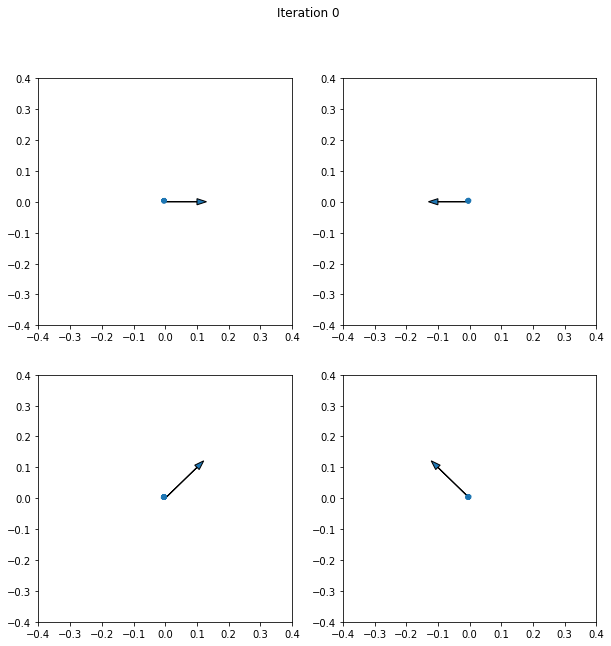

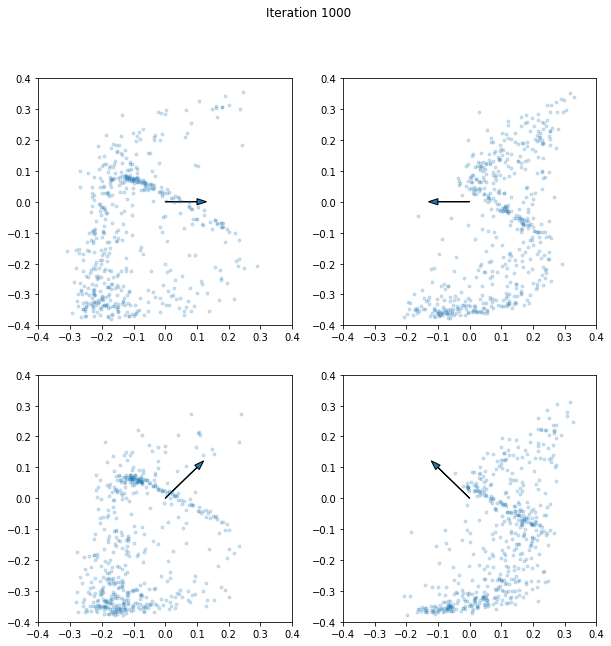

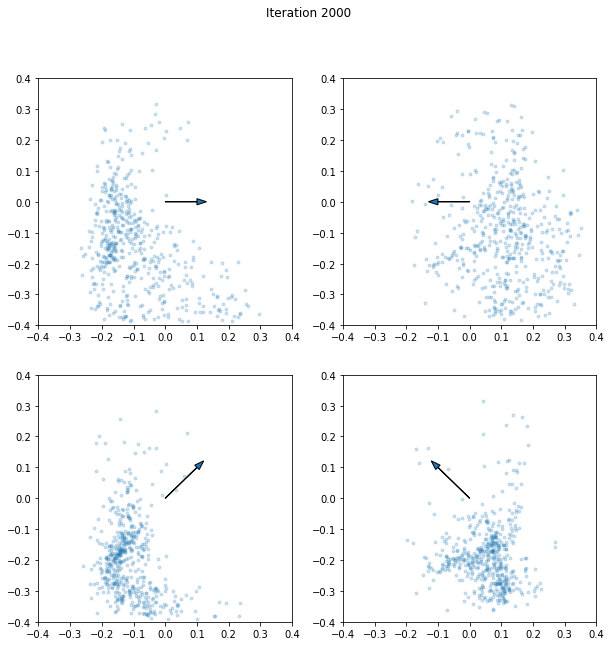

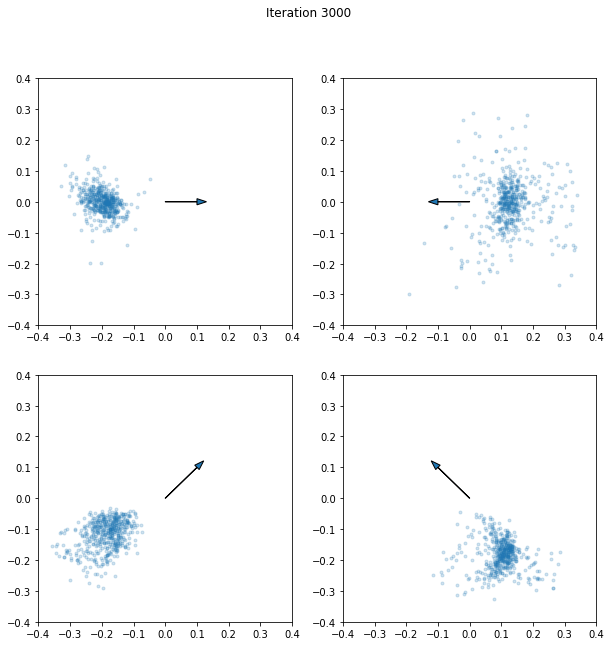

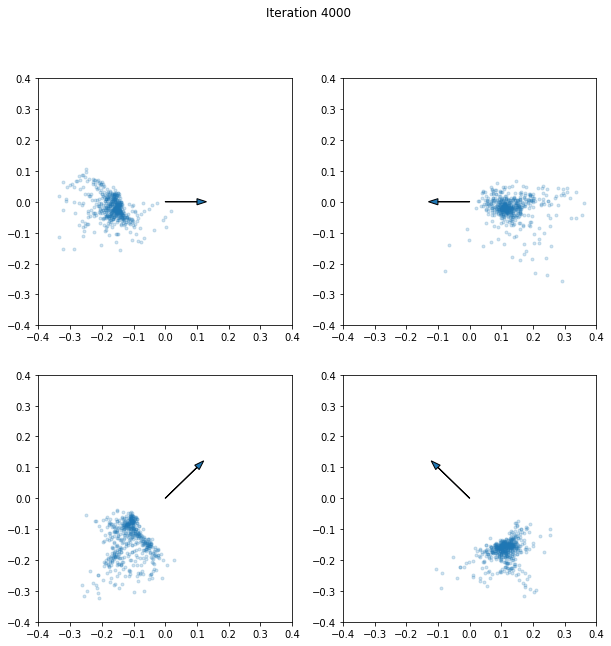

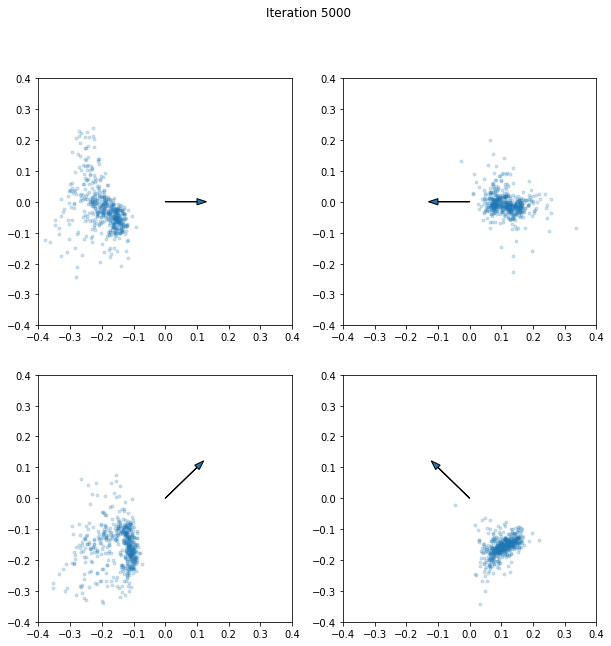

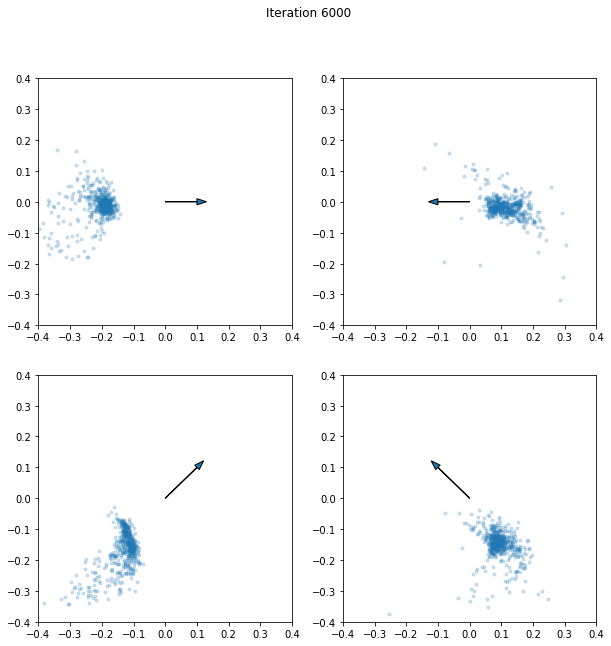

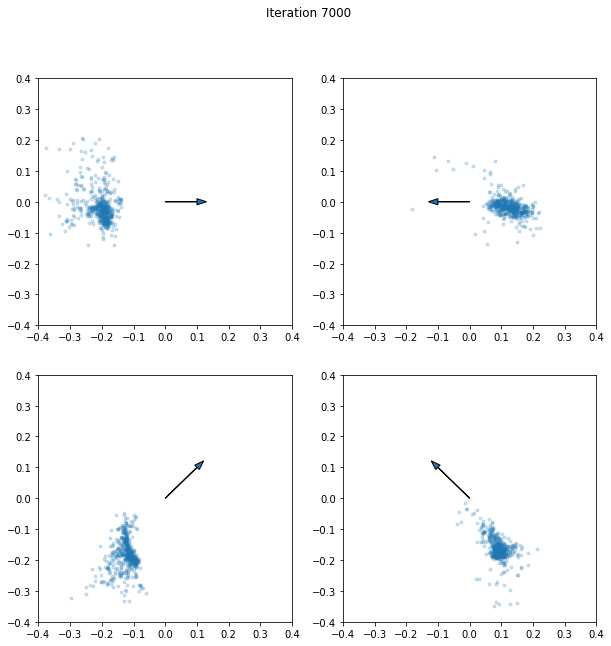

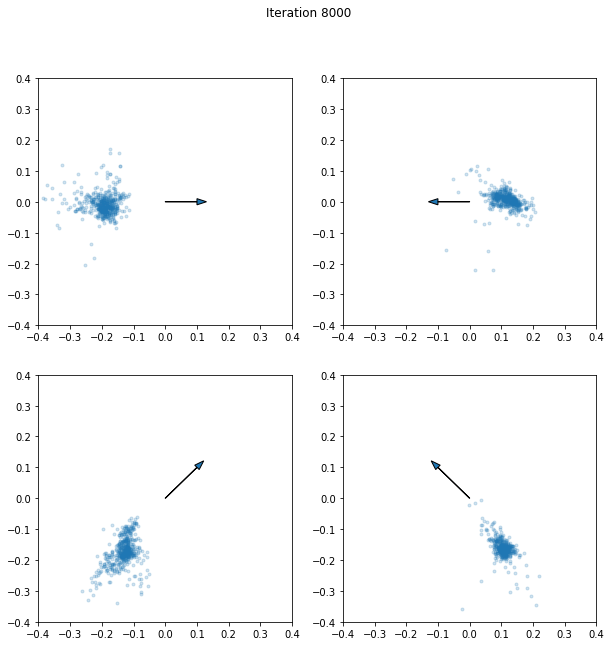

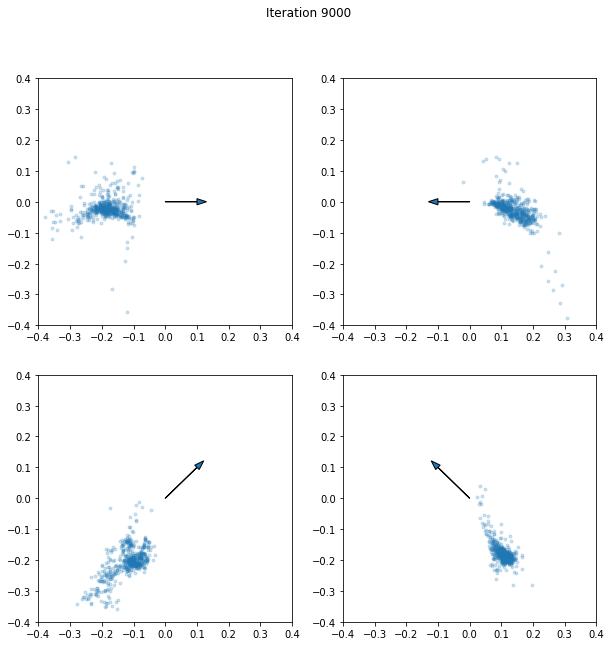

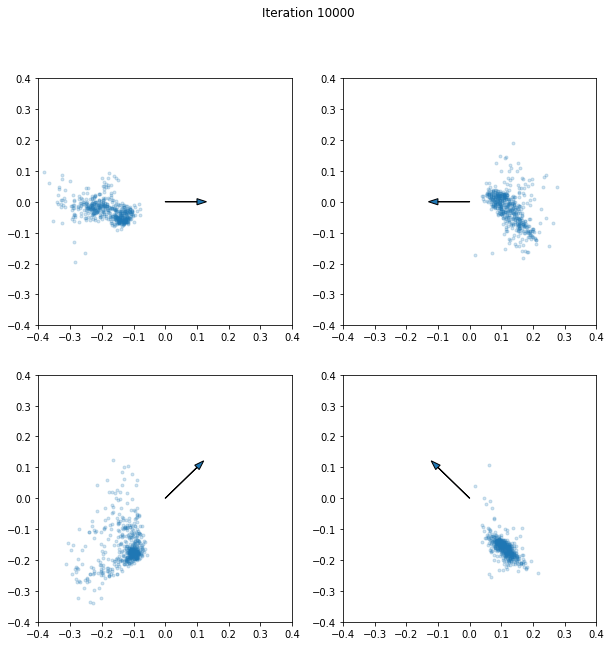

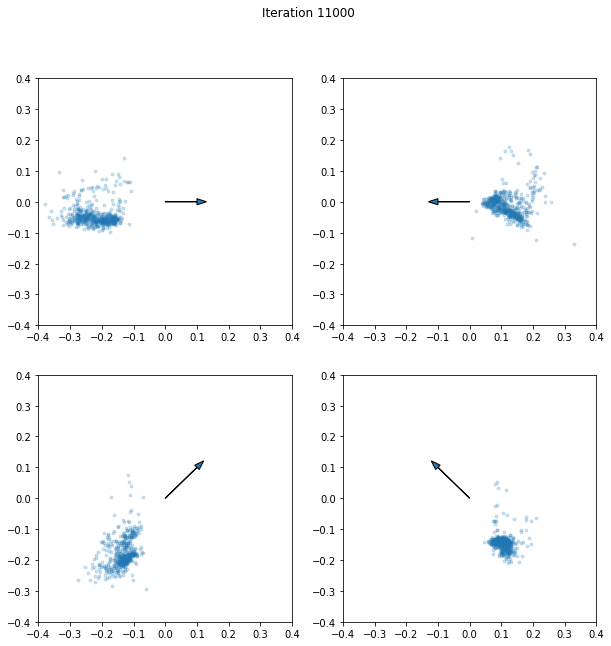

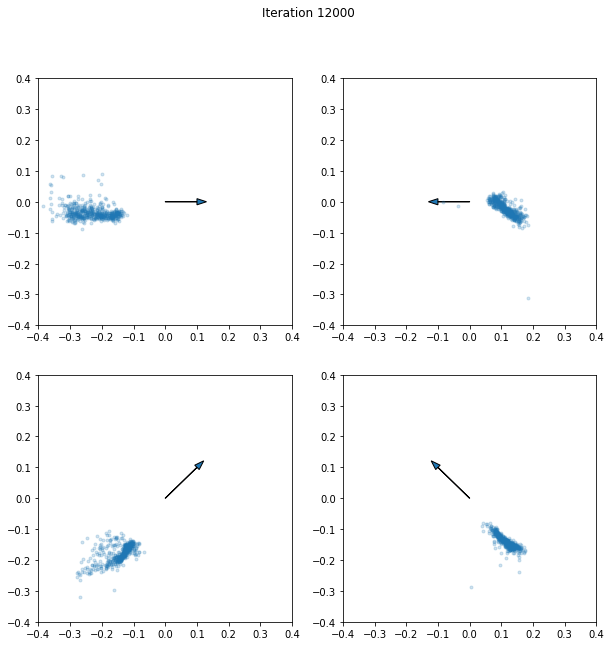

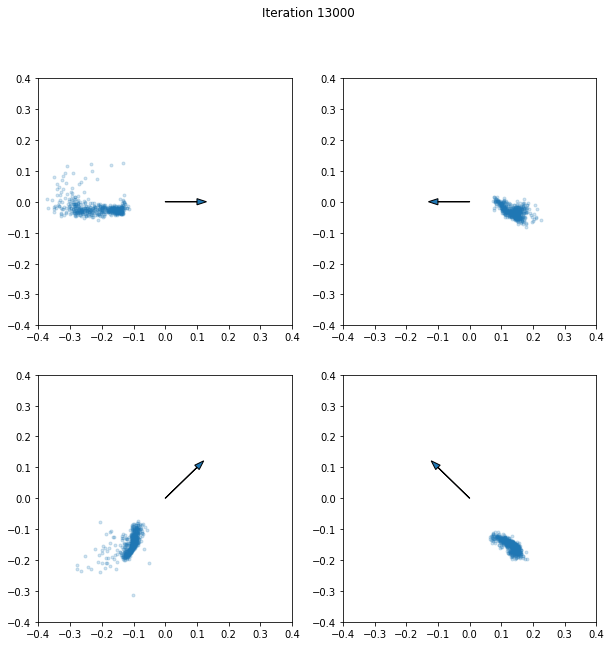

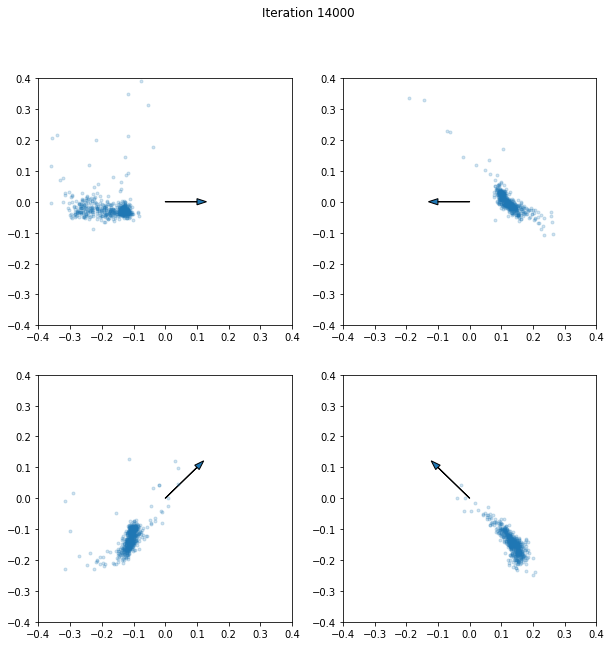

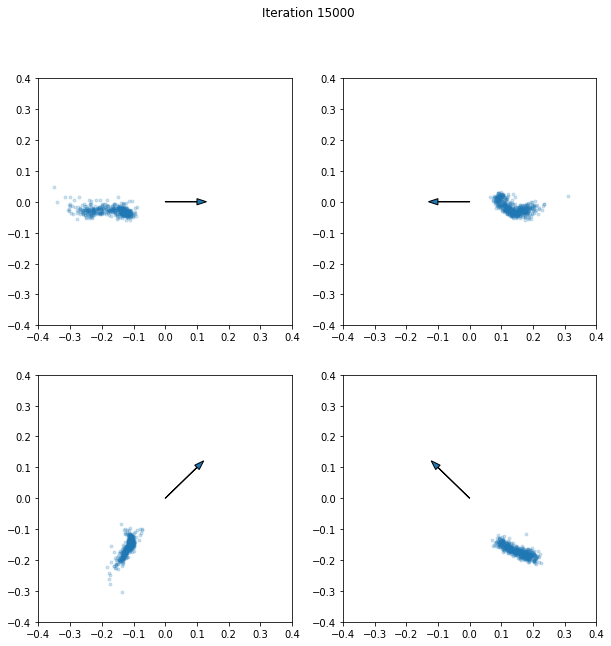

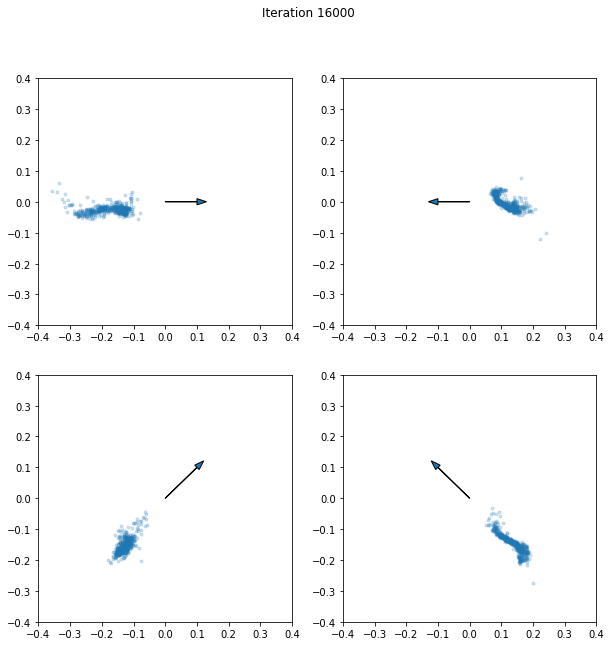

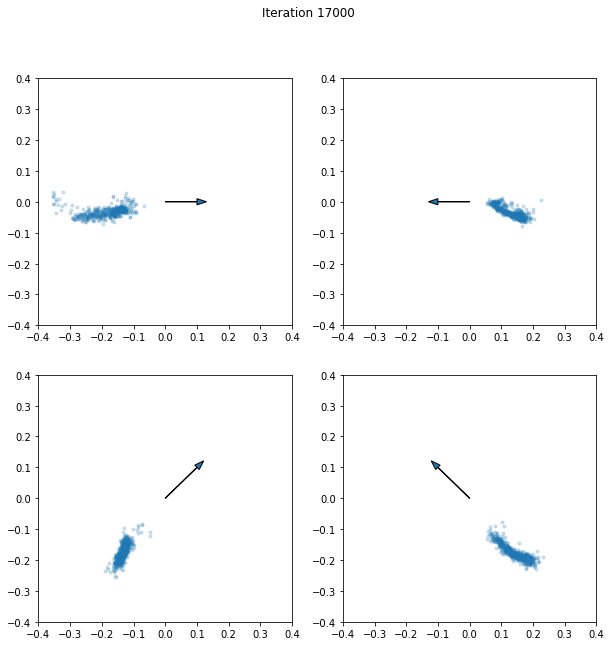

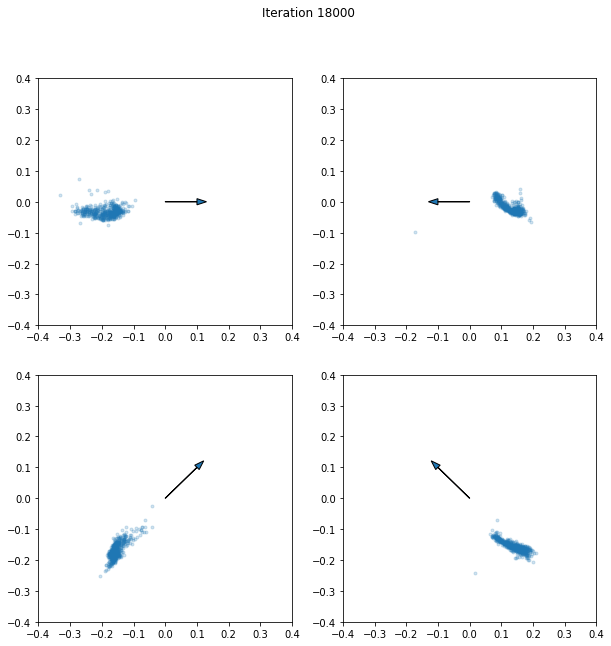

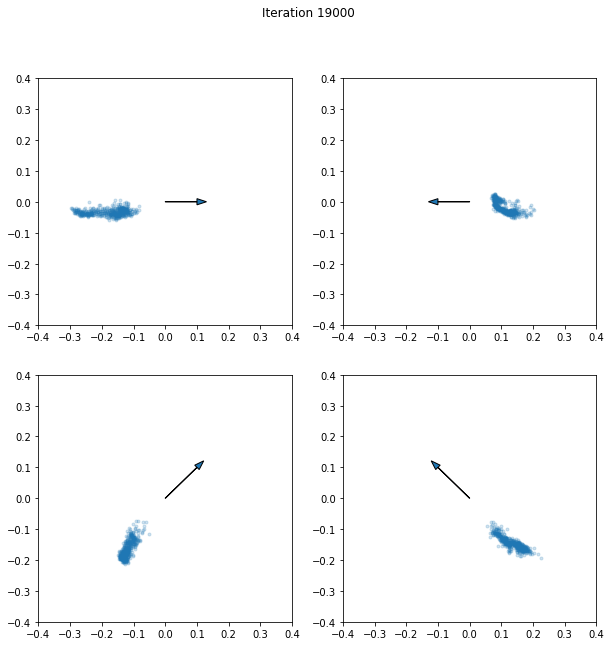

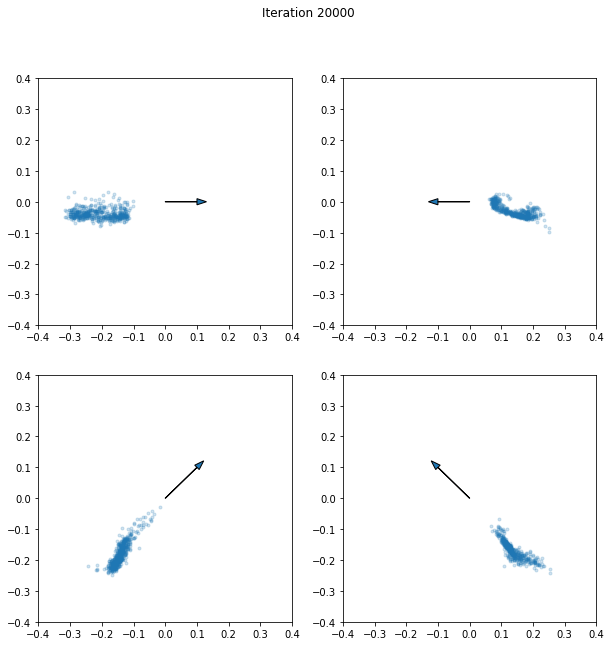

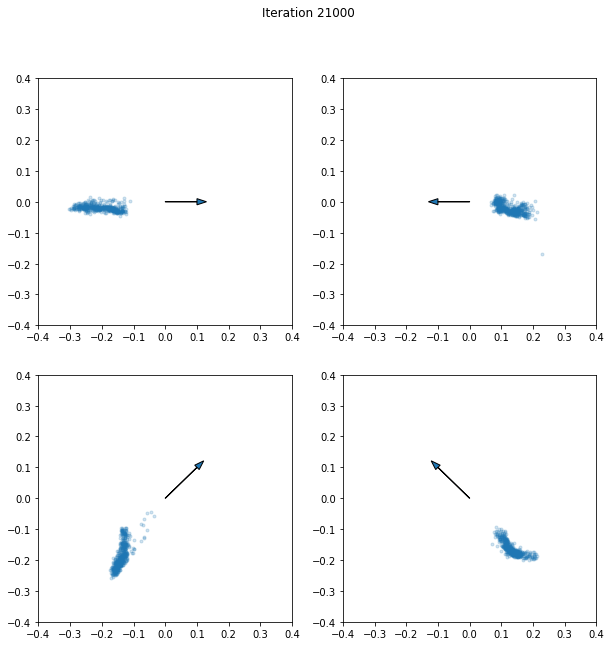

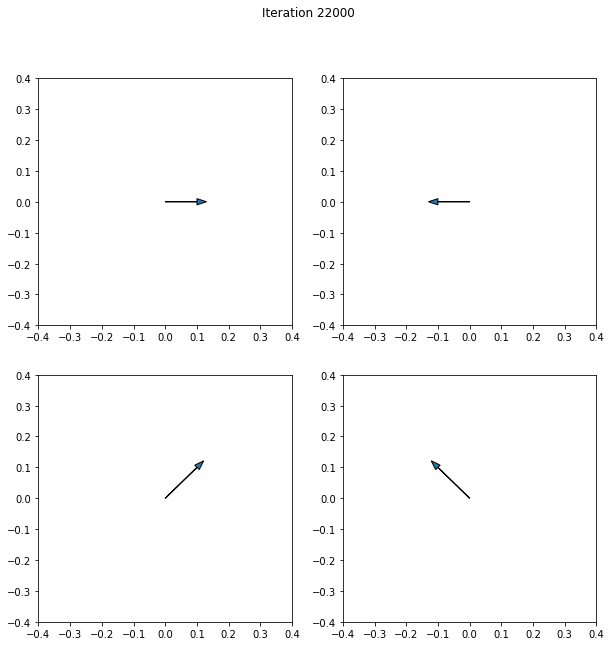

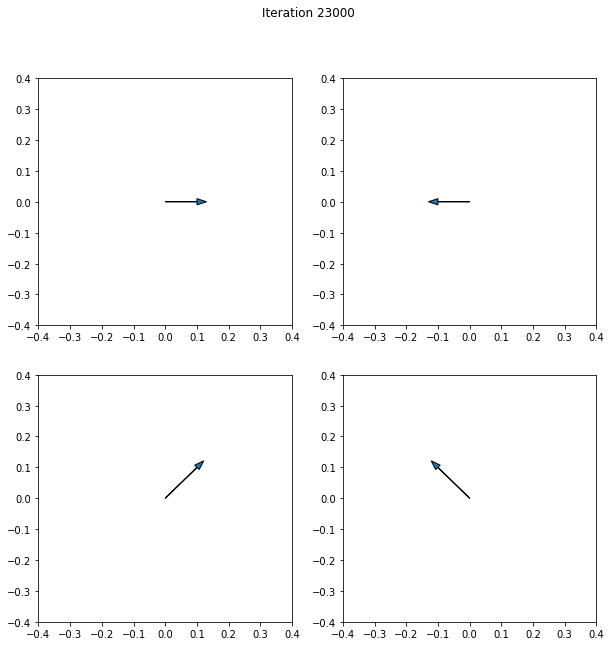

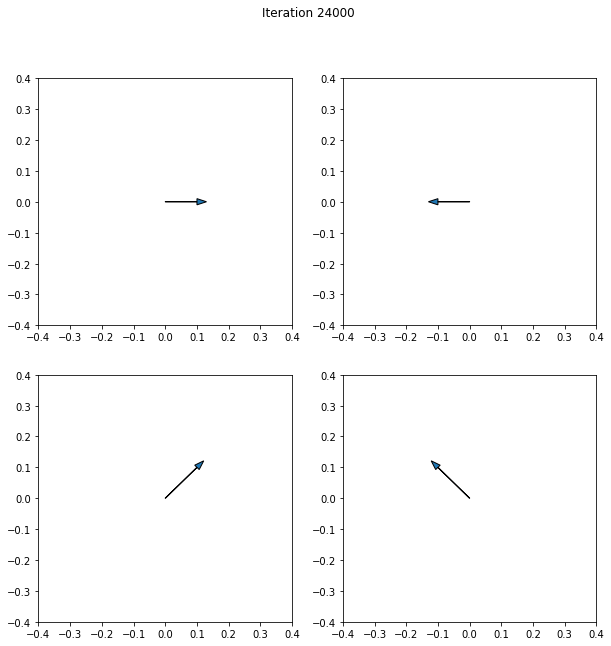

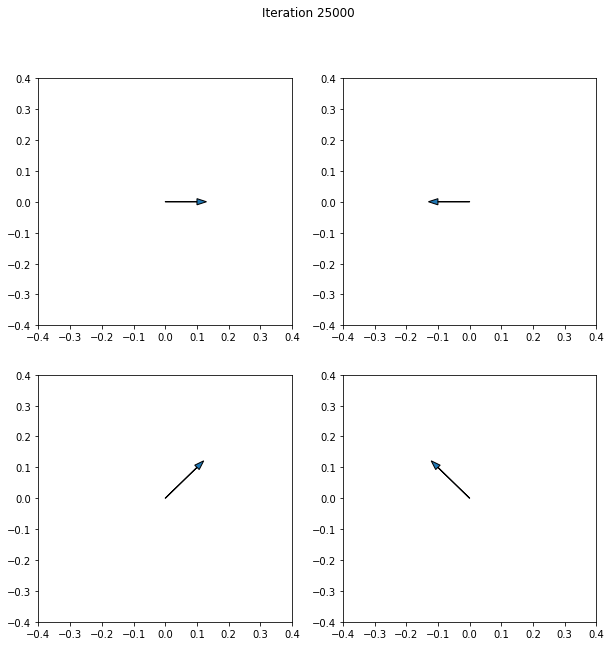

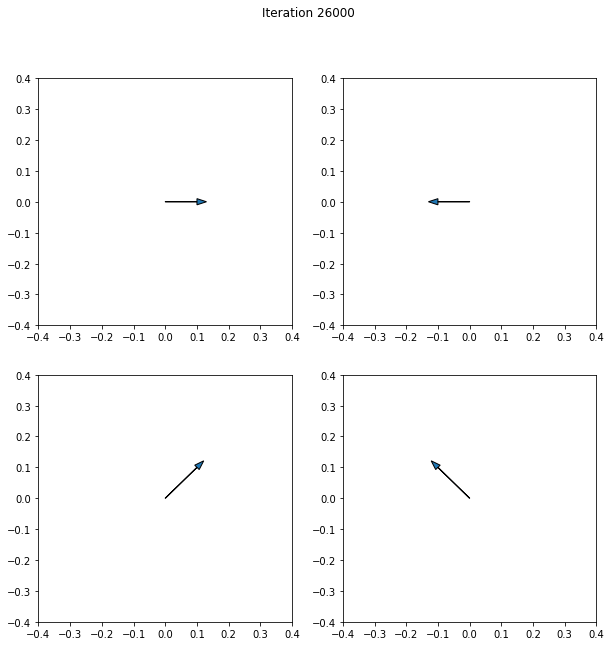

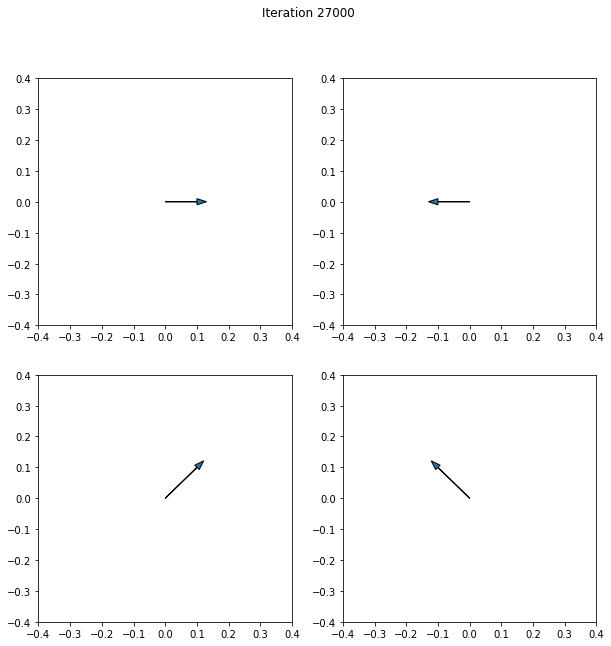

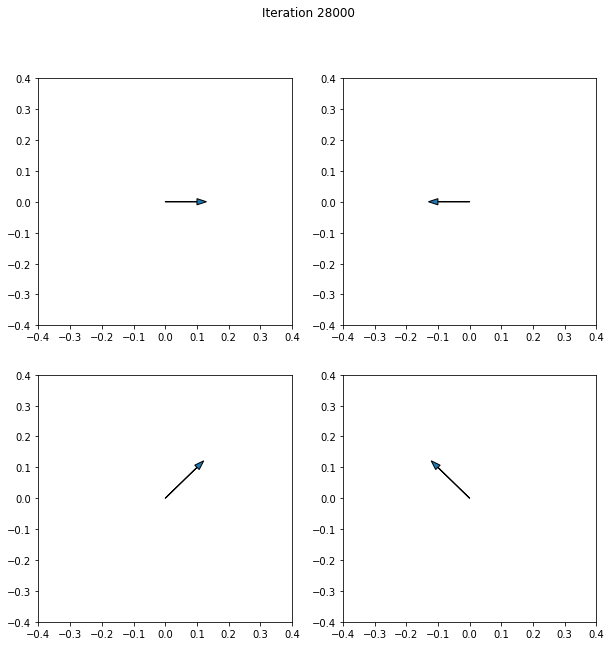

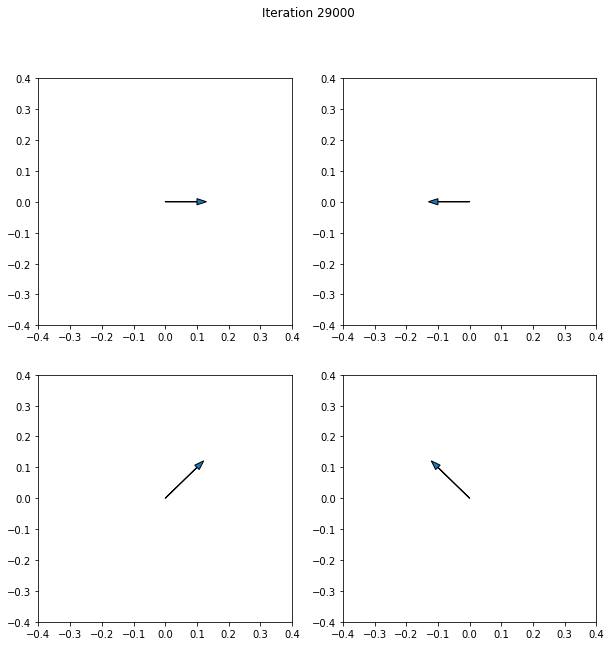

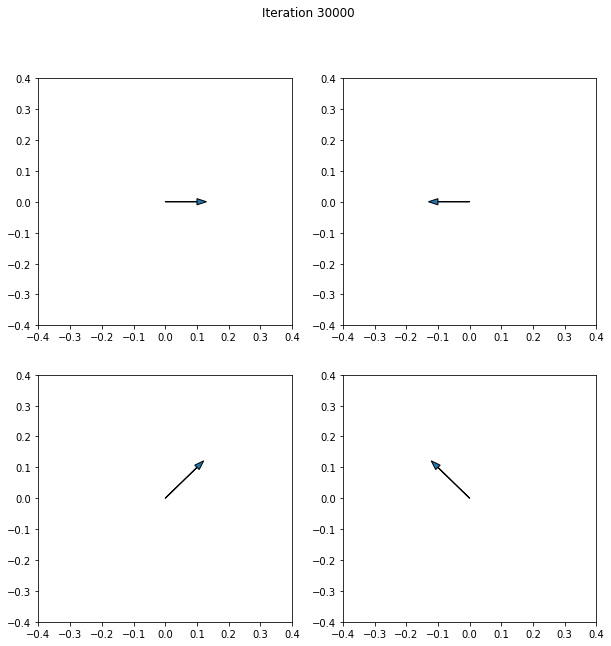

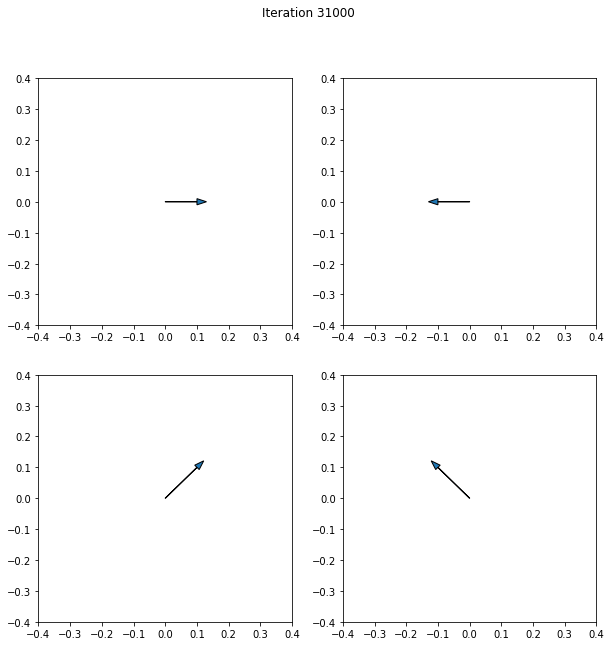

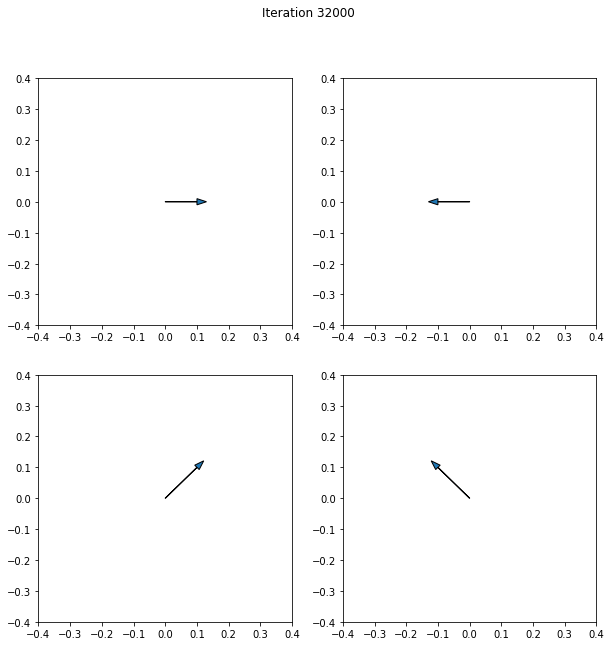

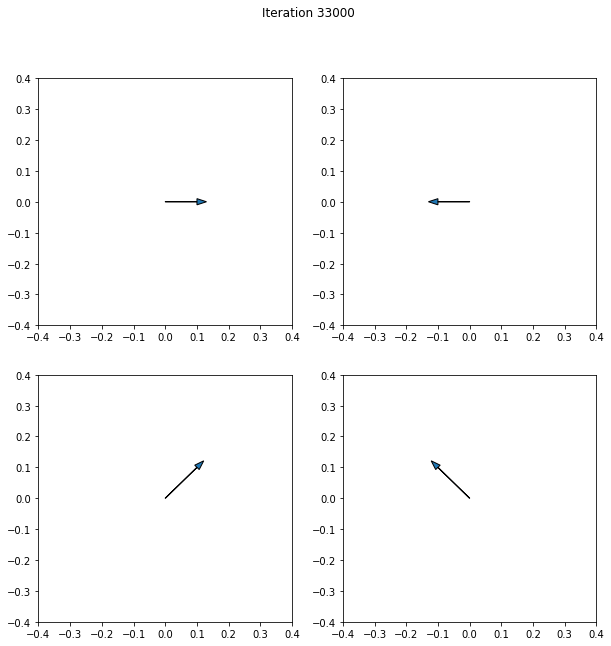

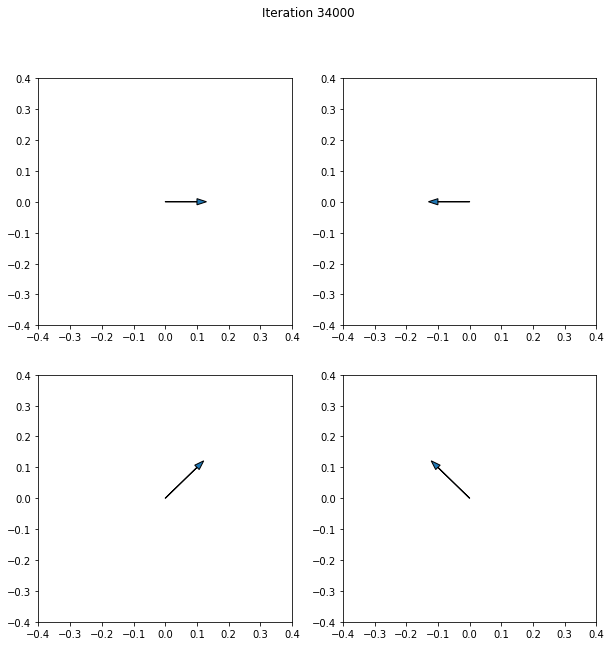

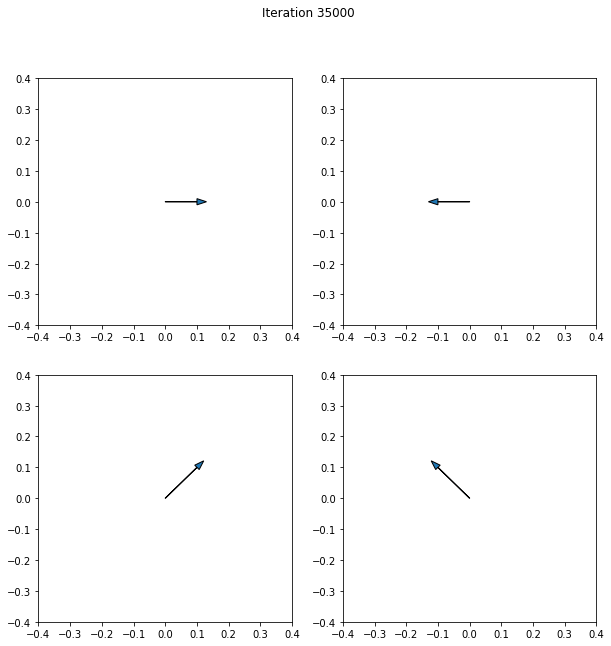

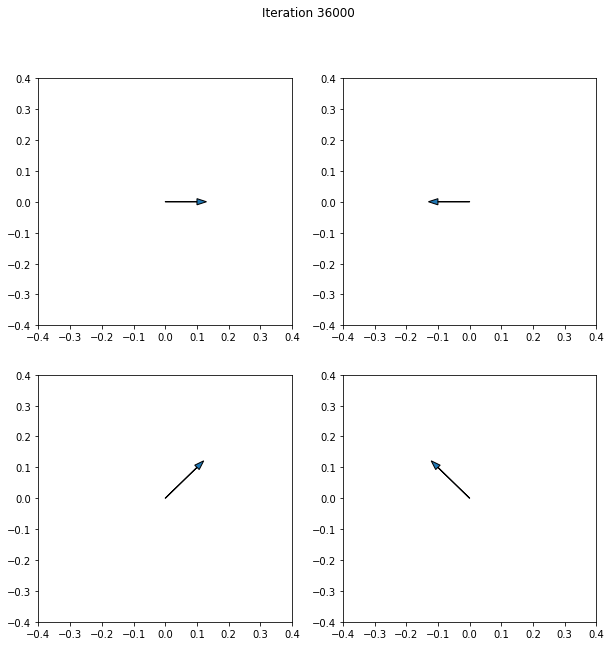

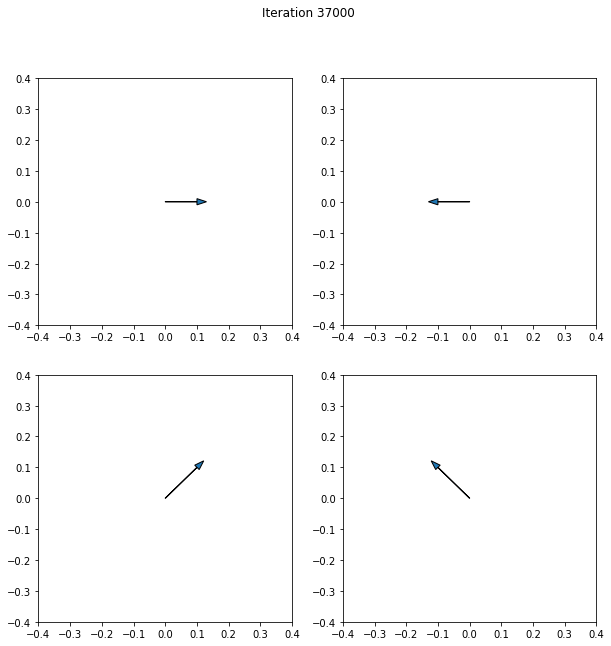

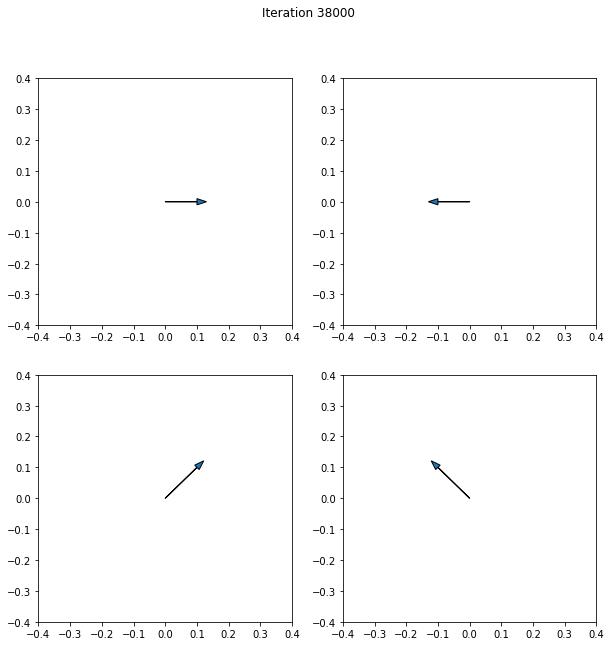

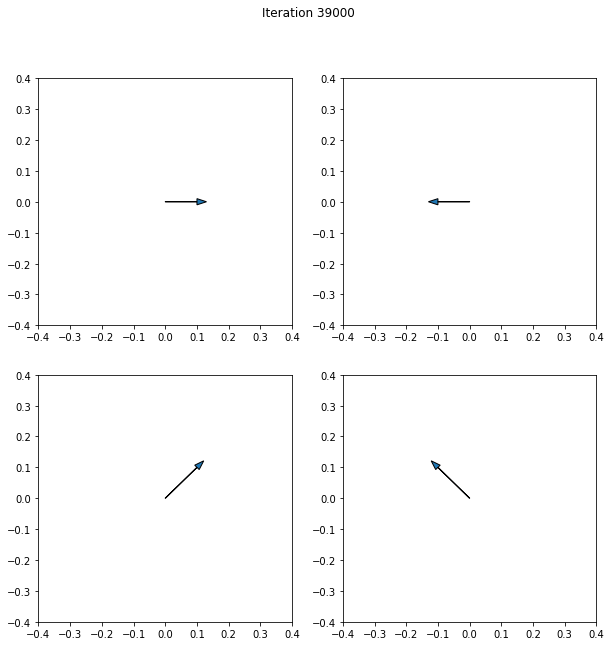

In [298]:
lr = 1e-4
gamma = 1
batch_size = 256
n_steps = 40000

generator = FeasibilityGenerator().cuda()
generator_opt = torch.optim.RMSprop(generator.parameters(), lr=lr, weight_decay=1e-2)

discriminator = Discriminator().cuda()
discriminator_opt = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

dataloader_feasibility = DataLoader(dataset_feasibility, batch_size=batch_size, shuffle=True)
logger = SummaryWriter('./runs/gan')

replay_dataset = []
replay_dataloader = DataLoader(replay_dataset, batch_size=batch_size, shuffle=True)
generator.train()
discriminator.train()

models = dict()

all_parameters = list(generator.parameters())
all_parameters.extend(discriminator.parameters())

labels_real = Variable(torch.ones(batch_size, 1)).cuda()
labels_fake = Variable(torch.zeros(batch_size, 1)).cuda()

step = -1
    
while True:
    for O, R in dataloader_feasibility:
        step += 1
        R = robot_norm(Variable(R.cuda()))
        O = obs_norm(Variable(O.cuda()))

        # Train discriminator
        # - train real
        discriminator.zero_grad()
        logits, D = discriminator(O, R)
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = -torch.log(D).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator real mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()
        
        # - train fake
        discriminator.zero_grad()
        R_ = generator(O)
        if len(replay_dataset) > 0 and np.random.rand() < 0.5:
            o, r = next(iter(replay_dataloader))
            O_replay = Variable(o.cuda())
            R_ = Variable(r.cuda())
            logits, D = discriminator(O_replay, R_.detach())
        else:
            logits, D = discriminator(O, R_.detach())
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = torch.log(D).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator fake mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()

        # Train generator
        generator.zero_grad()
        R_ = generator(O)
        replay_dataset.extend(list(zip(O.data, R.data)))
        logits, D = discriminator(O, R_)
        loss_generator = -torch.log(D).mean()
        loss_generator.backward()
        generator_opt.step()
        
        if step % 1000 == 0:
            plot_generator(generator, step)
            with open('./generator_models/model_{}.pkl'.format(step), 'wb') as f:
                torch.save(generator.state_dict(), f)

        if step == n_steps - 1:
            break
    if step == n_steps - 1:
        break

In [836]:
class GeneratorProduction(torch.nn.Module):
    
    def __init__(self, generator):
        super(GeneratorProduction, self).__init__()
        self.generator = FeasibilityGenerator()
        self.obj_norm = Normalization(5)
        self.obj_norm.std = torch.cuda.FloatTensor([0.16, 0.16, 0.5, 0.5, 2.0]) # picked by eyeballing

        self.rob_norminv = NormalizationInverse(4)
        self.rob_norminv.std = torch.cuda.FloatTensor([0.4, 0.4, 1.0, 1.0]) # picked by eyeballing
    
    def forward(self, obj, obj_delta):
        """
        obj       : (width, height, x_obj, y_obj, θ_obj)
        obj_delta : (dx, dy, dθ)
        """
        obj_delta_ = Variable(torch.zeros(obj.size(0), 5))
        θ = obj[:, -1]
        obj_delta_[:, :2] = obj[:, :2]
        obj_delta_[:, 2] =  torch.cos(θ) * obj_delta[:, 0] + torch.sin(θ) * obj_delta[:, 1]
        obj_delta_[:, 3] = -torch.sin(θ) * obj_delta[:, 0] + torch.cos(θ) * obj_delta[:, 1]
        obj_delta_[:, 4] = obj_delta[:, -1]
        y = self.rob_norminv(self.generator(self.obj_norm(obj_delta_)))
        y[:, 2] = torch.atan2(y[:, 3], y[:, 2])
        # invariant: y is now robot position in object frame
        # convert to robot frame
        y_rob = Variable(torch.zeros(obj.size(0), 3))
        y_rob[:, 0] = obj[:, 2] + torch.cos(θ) * y[:, 0] - torch.sin(θ) * y[:, 1]
        y_rob[:, 1] = obj[:, 3] + torch.sin(θ) * y[:, 0] + torch.cos(θ) * y[:, 1]
        θr = y[:, 2] + θ
        y_rob[:, 2] = torch.atan2(torch.sin(θr), torch.cos(θr))
        return y_rob
    

generator_production = GeneratorProduction(generator)
generator_production.generator.load_state_dict(generator.state_dict())
generator_production = generator_production.cpu()
generator_production.eval()

o = Variable(torch.FloatTensor([[0.13, 0.13, 1.0, 1.0, -np.pi / 2]]))
do = Variable(torch.FloatTensor([[0.0, -0.1, 0.0]]))
print(generator_production(o, do).data.numpy().flatten())

[ 0.96803659  1.13881195 -1.10584879]


In [493]:
0.33 + np.pi / 2

1.9007963267948966

# Pushability

$$p(x_t'|x_t)$$

## Datasets

In [ ]:
# sort in order
dataset_pushability = dataset[['y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']] # skip u_4 because always 0
dataset_pushability = dataset_pushability[(dataset_pushability[['y\'_0', 'y\'_1', 'y\'_2']].abs().max(axis=1) > 1e-1)]
# Decide where to split in training/validation/test
train_cut = int(len(dataset_pushability) * 0.9)
valid_cut = train_cut + int(len(dataset_pushability) * 0.05)
dataset_pushability_train_ = dataset_pushability[:train_cut]
dataset_pushability_val_ = dataset_pushability[train_cut:valid_cut]
dataset_pushability_test_ = dataset_pushability[valid_cut:]

## Normalize by training set statistics
training_pushability_µ = dataset_pushability_train_.mean().values.astype(np.float32)
training_pushability_σ = dataset_pushability_train_.std().values.astype(np.float32)
dataset_pushability_train = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_val = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_test = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('y\'')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('y\'')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_pushability_train = get_dataloader(dataset_pushability_train)
dataloader_pushability_val = get_dataloader(dataset_pushability_val, batch_size=512)
dataloader_pushability_test = get_dataloader(dataset_pushability_test, batch_size=512)
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

# Models:

In [ ]:
n_residual_units = 1
hidden_size = 256
X, Y = next(iter(dataloader_pushability_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
pushability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

pushability_std = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(pushability_mean.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(pushability_std.parameters(), weight_decay=1e-4)

logger_train = SummaryWriter('runs/resid-1-pushability-train')
logger_valid = SummaryWriter('runs/resid-1-pushability-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
while True:
    for batch in dataloader_pushability_train:
        pushability_mean.train()
        pushability_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = pushability_mean(X)
        Y_var_pred = pushability_std(X)

        pushability_mean.zero_grad()
        pushability_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 10 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            pushability_mean.eval()
            pushability_std.eval()
            val_batch = next(iter(dataloader_pushability_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = pushability_mean(X)
            Y_var_pred = pushability_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = pushability_mean.state_dict()
                best_var_model = pushability_std.state_dict()

        step += 1
        if step >= 100000:
            break
    if step >= 100000:
        break

In [ ]:
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

pushability_norm = Normalization(5)
pushability_norm.mean = torch.from_numpy(training_pushability_μ[3:])
pushability_norm.std = torch.from_numpy(training_pushability_σ[3:])

pushability_norminv = NormalizationInverse(3)
pushability_norminv.mean = torch.from_numpy(training_pushability_μ[:3])
pushability_norminv.std = torch.from_numpy(training_pushability_σ[:3])

In [ ]:
with open('./saved_models/pushability_models.pkl', 'wb') as f:
    model_dict = {
        'mean_model': pushability_mean.state_dict(),
        'std_model': pushability_std.state_dict(),
        'norm': pushability_norm.state_dict(),
        'norm_inv': pushability_norminv.state_dict(),
        'n_features_in': pushability_x_size,
        'n_features_out': pushability_y_size,
        'n_hidden_units': 256,
        'n_residual_units': 1,
    }
    pickle.dump(model_dict, f)

In [ ]:
pushability_mean.eval()
pushability_std.eval()
pushability_mean.load_state_dict(best_mean_model)
pushability_std.load_state_dict(best_var_model)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

res = 16
img = np.eye(res)
p1 = axs[0].imshow(img, extent=[-1, 1, -1, 1], vmin=0.0, vmax=0.5, interpolation='gaussian')
std1 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
std2 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
axs[0].set_title('Translation')
axs[2].set_title('Parameter')
axs[2].set_xlim(0, 32)
axs[2].set_ylim(0, 2.0)
θ_data = []
θ_plot, = axs[1].plot(θ_data)
axs[1].set_xlim(0, 32)
axs[1].set_ylim(0, 2)
axs[1].set_title('Rotation standard dev.')
ydata = []
argplot, = axs[2].plot(ydata)
    
# animation function. This is called sequentially
def animate(arg):
    x = (np.array([[0.35, 0.0024, 0.195 * arg * 2, 0.12, 0.12]]) - training_pushability_μ[3:]) / training_pushability_σ[3:]
    X = Variable(torch.from_numpy(x.astype(np.float32))).cuda()
    Y_mean_pred = pushability_mean(X).cpu().data.numpy()
    Y_std = pushability_std(X).cpu().data.numpy()
    
    µ = Y_mean_pred[0, :] * training_pushability_σ[:3] + training_pushability_μ[:3]
    σ = Y_std * training_pushability_σ[:3]
    Σ = np.diag(σ.flatten())

    obs = dataset_pushability_train.iloc[0].values[3:].reshape(-1, 1)
    obs[0, 0] = arg
    for i, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            img[j, i] = multivariate_normal.pdf([x, y, 0], mean=µ.flatten(), cov=Σ)
    p1.set_data(img)
    σ_ = σ[0, :2].mean()
    std1.set_radius(σ_)
    std2.set_radius(σ_ * 2)
    ydata.append(arg)
    θ_data.append(σ[0, 2])
    argplot.set_data(range(len(ydata)), ydata)
    argplot.set_data(range(len(ydata)), ydata)
    θ_plot.set_data(range(len(θ_data)), θ_data)
    
    return p1, std1, std2, argplot, θ_plot

# call the animator. blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, frames=np.linspace(0.0, 2.0, 32), interval=100, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

# Feasibility
Predicts $p(x_{robot}|x_{target}, x_{target}')$

In [ ]:
dataset_feasibility = dataset[['x_0', 'x_1', 'x_2', 'x_3',
                               'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2',
                               'm', 'I', 'µ', 'w', 'h']]
# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_feasibility_train_ = dataset_feasibility[:train_cut]
dataset_feasibility_val_ = dataset_feasibility[train_cut:valid_cut]
dataset_feasibility_test_ = dataset_feasibility[valid_cut:]

# Normalize by training set statistics
training_feasibility_µ = dataset_feasibility_train_.mean()
training_feasibility_σ = dataset_feasibility_train_.std()
dataset_feasibility_train = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_val = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_test = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('x')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('x')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_feasibility_train = get_dataloader(dataset_feasibility_train)
dataloader_feasibility_val = get_dataloader(dataset_feasibility_val, batch_size=128)
dataloader_feasibility_test = get_dataloader(dataset_feasibility_test, batch_size=128)
X, Y = next(iter(dataloader_feasibility_train))
feasibility_x_size, feasibility_y_size = X.size(1), Y.size(1)
dataset_feasibility_train.iloc[:10]

# Models:

In [ ]:
hidden_size = 256
n_residual_units = 1

feasibility_mean = torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size)
).cuda()

feasibility_std= torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
weight_decay = 1e-4
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(feasibility_mean.parameters(), weight_decay=weight_decay)
std_loss_fn = gaussian_likelihood()
std_optim = torch.optim.Adam(feasibility_std.parameters(), weight_decay=weight_decay)

time_str = datetime.datetime.now().strftime('%H:%M')
name = 'runs/feasibility'
logger_train = SummaryWriter(name + '-train')
logger_valid = SummaryWriter(name + '-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_std = None
step = 0
for _ in range(1024):
    for batch in dataloader_feasibility_train:
        feasibility_mean.train()
        feasibility_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = feasibility_mean(X)
        Y_std_pred = feasibility_std(X)

        feasibility_mean.zero_grad()
        feasibility_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = std_loss_fn(Y_mean_pred, Y_std_pred, Y)
        nll.backward()
        std_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            feasibility_mean.eval()
            feasibility_std.eval()
            val_batch = next(iter(dataloader_feasibility_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = feasibility_mean(X)
            Y_std_pred = feasibility_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = std_loss_fn(Y_mean_pred, Y_std_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = feasibility_mean.state_dict()
                best_std_model = feasibility_std.state_dict()

        step += 1

In [ ]:
feasibility_norm = Normalization(feasibility_x_size).cuda()
feasibility_norm.mean = torch.FloatTensor(training_feasibility_μ[4:].values).cuda()
feasibility_norm.std = torch.FloatTensor(training_feasibility_σ[4:].values).cuda()
feasibility_norminv = Normalization(feasibility_y_size).cuda()
feasibility_norminv.mean = torch.FloatTensor(training_feasibility_μ[:4].values).cuda()
feasibility_norminv.std = torch.FloatTensor(training_feasibility_σ[:4].values).cuda()

In [ ]:
from matplotlib.patches import Ellipse

feasibility_mean.load_state_dict(best_mean_model)
feasibility_std.load_state_dict(best_std_model)
feasibility_mean.eval()
feasibility_std.eval()

#with open('./saved_models/feasibility_models.pkl', 'wb') as f:
#    model_dict = {
#        'mean_model': feasibility_mean.state_dict(),
#        'std_model': feasibility_std.state_dict(),
#        'norm': feasibility_norm.state_dict(),
#        'norm_inv': feasibility_norminv.state_dict(),
#        'n_features_in': feasibility_x_size,
#        'n_features_out': feasibility_y_size,
#        'n_hidden_units': 256,
#        'n_residual_units': 1,
#    }
#    pickle.dump(model_dict, f)

fig, ax = plt.subplots(figsize=(6, 6))
row = dataset.sample(n=1).iloc[0]
#val_batch = next(iter(dataloader_feasibility_val))
print(row)
X = Variable(torch.cuda.FloatTensor([
    row[['y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']]
]))
#X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = feasibility_mean(feasibility_norm(X))
Y_std_pred = feasibility_std(feasibility_norm(X))
for _ in range(512):
    y_ = feasibility_norminv(Y_mean_pred + Y_std_pred * Variable(torch.randn(Y_mean_pred.size())).cuda())
    y = y_.cpu().data.numpy().flatten()
    plt.plot(y[0], y[1], 'bo', alpha=0.1)
plt.arrow(0, 0, row['y\'_0'], row['y\'_1'], head_width=0.05)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [ ]:
training_µ